In [1]:
from paths import models_folder, metadata_folder, latent_space_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_64_32_16_8_stride_4_B1H_Inst_min_max_abs_diff_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_min_max_abs_diff_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_min_max_abs_diff_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           512       
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           14368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            3600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 8)              9

Mar/01 22:29:14 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Mar/01 22:29:14 pyobsbox.generator INFO: shuffle: True
Mar/01 22:29:14 pyobsbox.generator INFO: seed: 42
Mar/01 22:29:14 pyobsbox.generator INFO: batch_size: 8192
Mar/01 22:29:14 pyobsbox.generator INFO: sequence_length: 2048
Mar/01 22:29:14 pyobsbox.generator INFO: n_bunches: 256
Mar/01 22:29:14 pyobsbox.generator INFO: __len__: 1040
Mar/01 22:29:14 pyobsbox.generator INFO: fetched_log_folder: None
Mar/01 22:29:14 pyobsbox.generator INFO: fetched_log_prefix: 
Mar/01 22:29:14 pyobsbox.generator INFO: normalization: min_max
Mar/01 22:29:14 pyobsbox.generator INFO: normalization_pre_split: False
Mar/01 22:29:14 pyobsbox.generator INFO: normalization_kwargs: {}
Mar/01 22:29:14 pyobsbox.generator INFO: abs_diff: True
Mar/01 22:29:14 pyobsbox.generator INFO: diff: True
Mar/01 22:29:14 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/

In [9]:
print(train_metadata.shape)
train_metadata.head()

(266240, 11)


type  fill  beam plane  q           date_time  \
7245233  Inst  6859     1     h  7 2018-06-28 13:38:48   
6887959  Inst  7299     1     h  7 2018-10-14 02:16:14   
1618071  Inst  6663     1     h  7 2018-05-10 15:13:15   
6140818  Inst  6711     1     h  7 2018-05-22 15:04:14   
593698   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7245233  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6859/...        684   
6887959  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7299/...         48   
1618071  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6140818  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6711/...       2556   
593698   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7245233        658.0         464.0      65536  
6887959        967.0          41.0      65536  
1618071       2262.0        1660.0      65536  
6140818       3048.0        2262.0      65536  
593698        2374.0        1305.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
8755891  Inst  6706     1     h  7 2018-05-20 11:10:14   
483701   Inst  6245     1     h  7 2017-09-26 14:35:14   
8944144  Inst  6860     1     h  7 2018-06-29 02:19:14   
5204641  Inst  6343     1     h  7 2017-10-28 06:53:14   
8463163  Inst  7316     1     h  7 2018-10-19 06:48:42   

                                                      file  n_bunches  \
8755891  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/...        987   
483701   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   
8944144  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6860/...       2460   
5204641  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/...        908   
8463163  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7316/...        540   

         bunch_index  bunch_number  ts_length  
8755891        288.0         117.0      65536  
483701        1393.0         769.0      65536  
8944144       2389.0        1786.0      65536  
5204641       1110.0         594.0      65536  
8463163        669.0         485.0      65536

# Loss functions

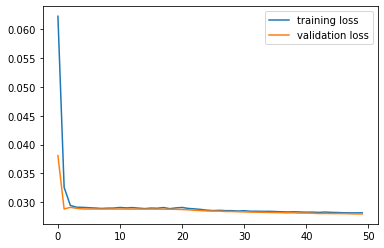

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 104s 2s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 7s 1s/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

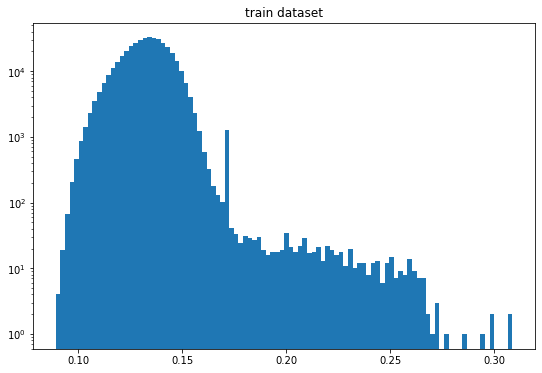

In [18]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.13303822327051598

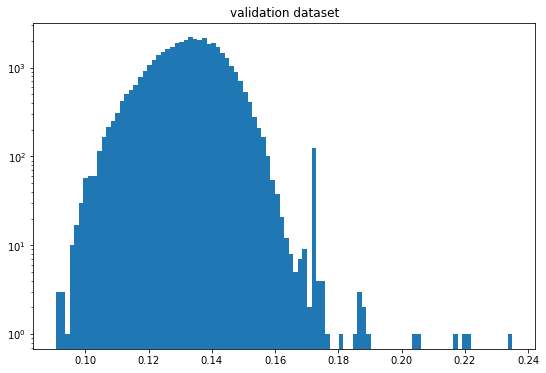

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.13251307816612273

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([303992, 304706, 402833, ..., 204757, 306176, 307589])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

#     axes[1].plot(np.cumsum(true_signal))
#     axes[1].plot(np.cumsum(pred_signal))
    return fig, axes

index:  303992
MAE:  0.3086549503211008
n_bunches       2556
bunch_index     1072
bunch_number     775
Name: 5984987, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_06h25m14s.h5


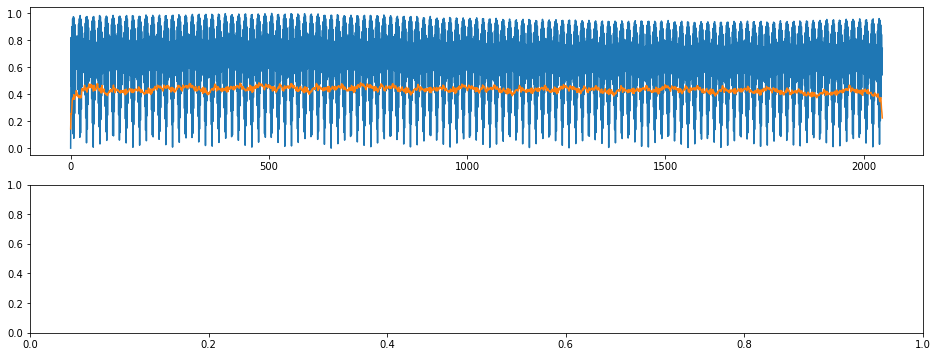

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  303992
MAE:  0.3086549503211008
n_bunches       2556
bunch_index     1072
bunch_number     775
Name: 5984987, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_06h25m14s.h5


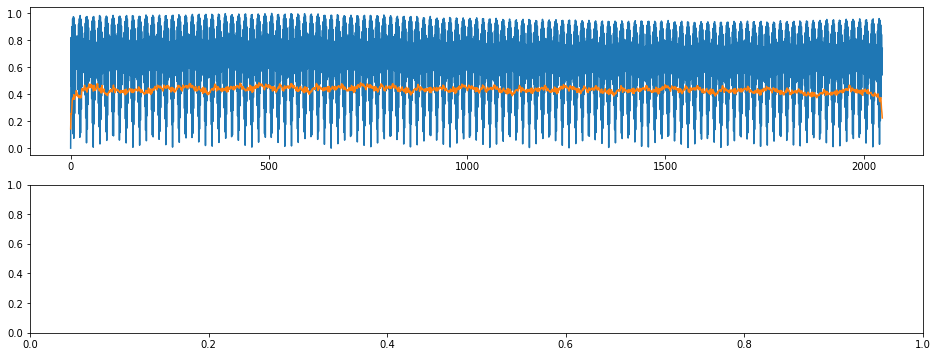

index:  304706
MAE:  0.30690072032504534
n_bunches       460
bunch_index     203
bunch_number     98
Name: 11657786, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h37m05s.h5


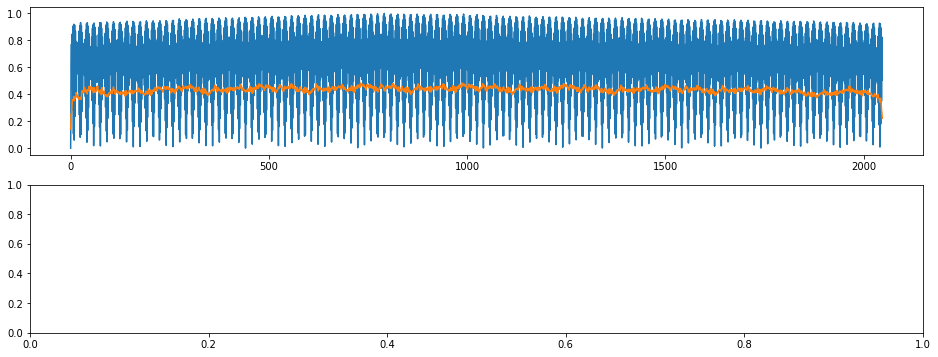

index:  402833
MAE:  0.2996689763172509
n_bunches       1916
bunch_index     3230
bunch_number    1794
Name: 3494424, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_08h45m15s.h5


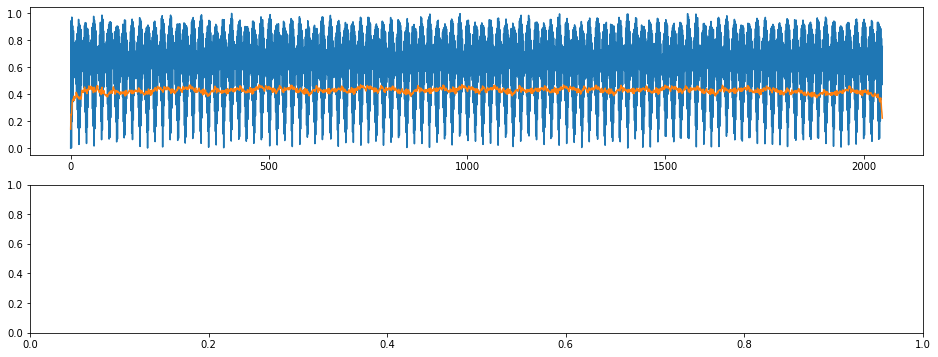

index:  402814
MAE:  0.2981678935017291
n_bunches       1916
bunch_index       87
bunch_number      37
Name: 10317612, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_00h23m15s.h5


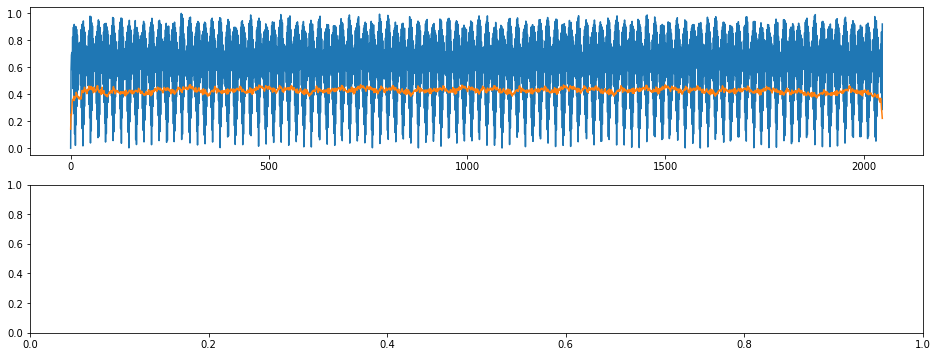

index:  407012
MAE:  0.29511578975452646
n_bunches       2460
bunch_index     1078
bunch_number     787
Name: 3625900, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6860/instability_data/06860_Inst_B1H_Q7_20180628_21h06m14s.h5


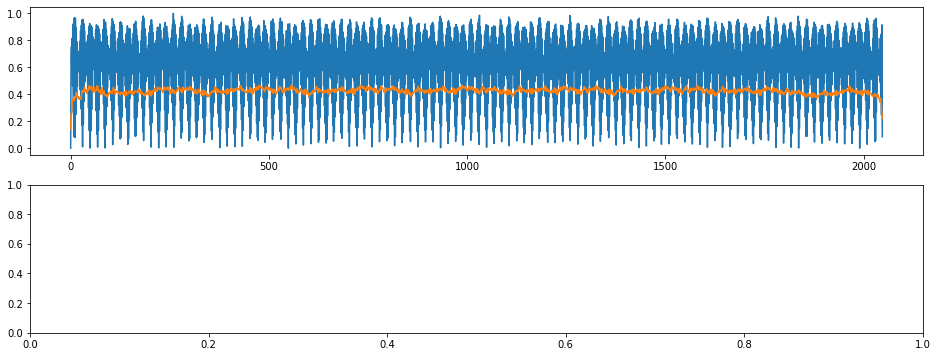

index:  306663
MAE:  0.28565129414596935
n_bunches       2556
bunch_index      821
bunch_number     588
Name: 3944765, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_23h30m14s.h5


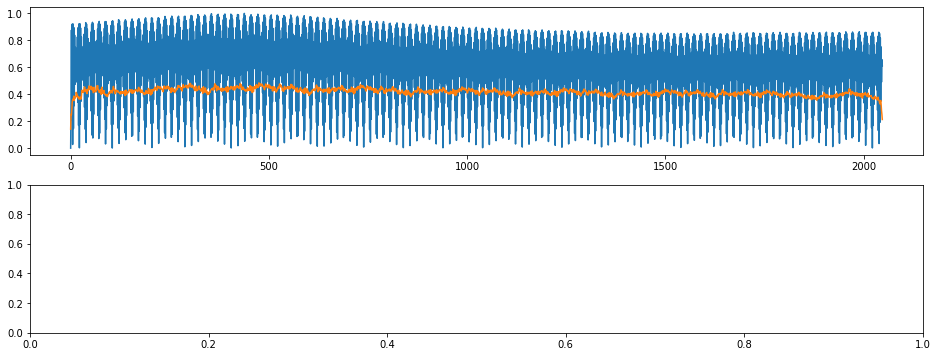

index:  278115
MAE:  0.275838904475578
n_bunches        924
bunch_index     1143
bunch_number     815
Name: 9468795, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_03h05m05s.h5


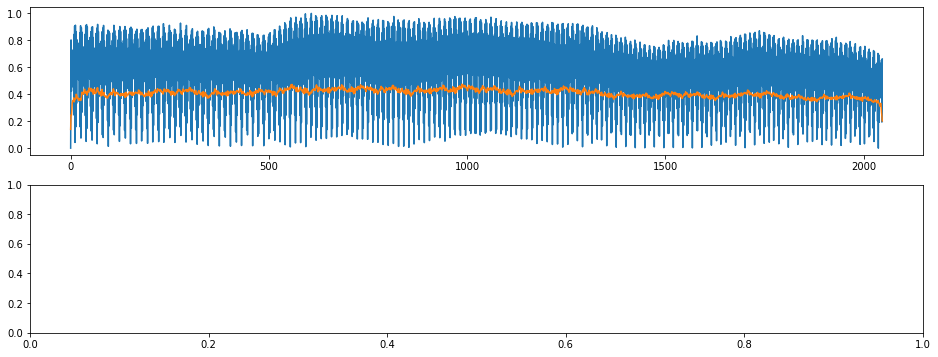

index:  386272
MAE:  0.2732793250717237
n_bunches       1551
bunch_index     2003
bunch_number     871
Name: 5515197, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180501_06h36m15s.h5


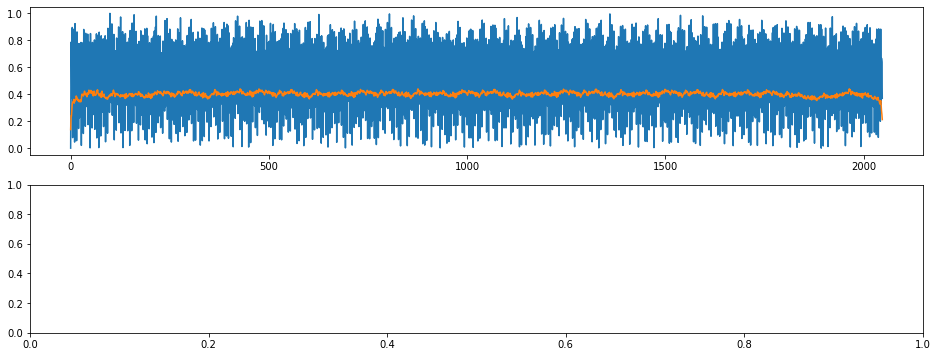

index:  406093
MAE:  0.27218627045589916
n_bunches       1452
bunch_index     1456
bunch_number     606
Name: 4570970, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180706_09h56m14s.h5


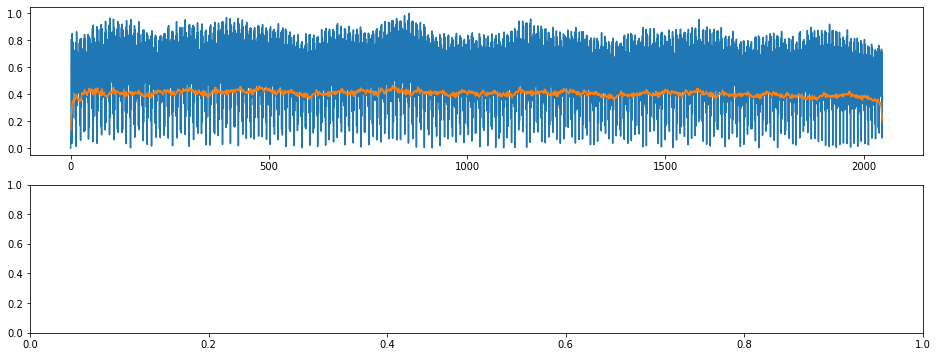

index:  388786
MAE:  0.2714875329570925
n_bunches       576
bunch_index     257
bunch_number     42
Name: 2634007, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7449/instability_data/07449_Inst_B1H_Q7_20181116_17h48m14s.h5


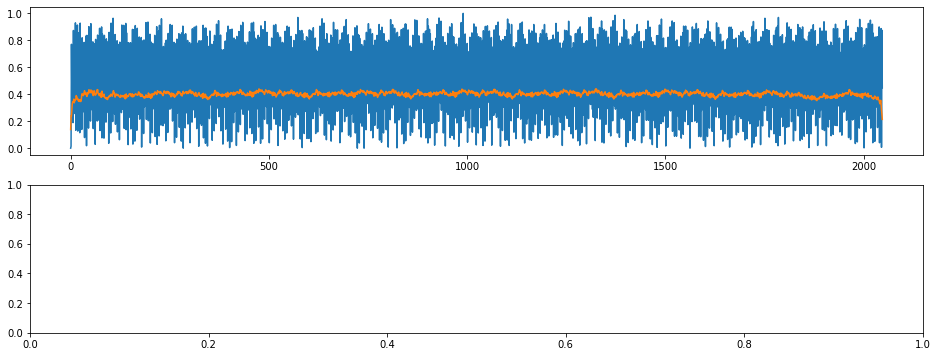

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  307589
MAE:  0.08913404150786977
n_bunches        648
bunch_index     1078
bunch_number     200
Name: 9999933, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_09h21m15s.h5


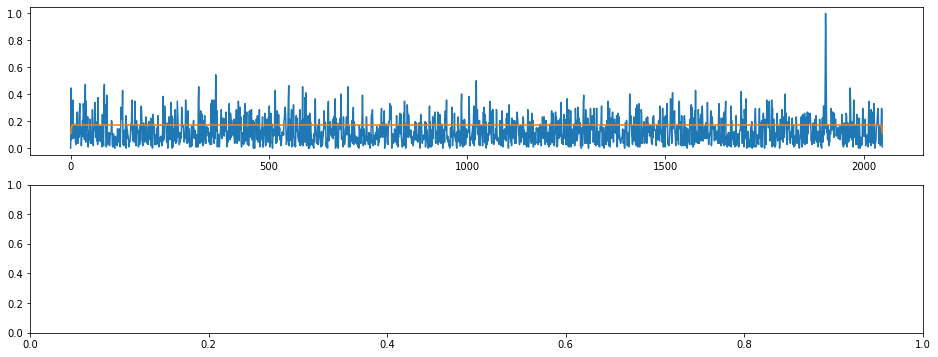

index:  306176
MAE:  0.0899495039493434
n_bunches       1836
bunch_index     2865
bunch_number    1531
Name: 7048207, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6268/instability_data/06268_Inst_B1H_Q7_20171003_13h28m22s.h5


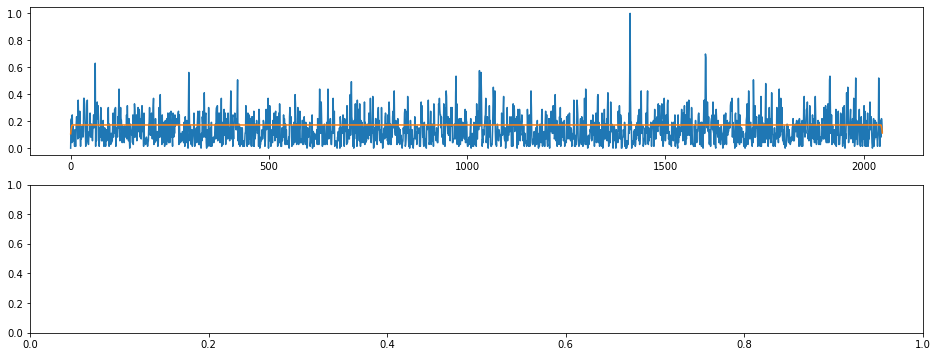

index:  204757
MAE:  0.09072664813084932
n_bunches       120
bunch_index     447
bunch_number     78
Name: 9159136, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7086/instability_data/07086_Inst_B1H_Q7_20180825_12h47m27s.h5


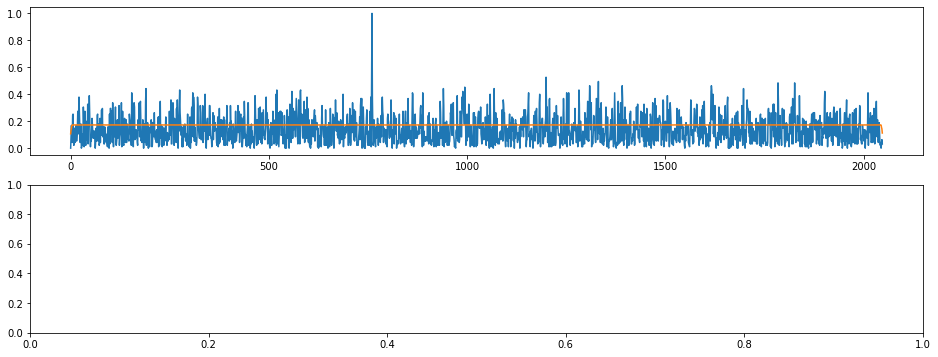

index:  298465
MAE:  0.09087737511156145
n_bunches       396
bunch_index      86
bunch_number     18
Name: 9130984, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6654/instability_data/06654_Inst_B1H_Q7_20180507_22h10m42s.h5


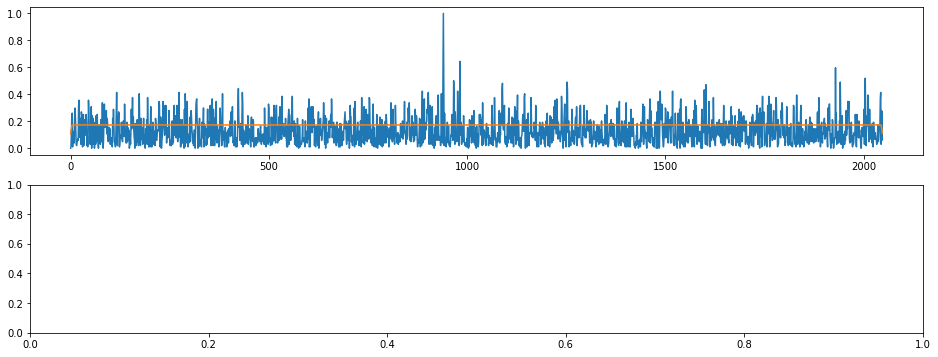

index:  55364
MAE:  0.09160739336444335
n_bunches       1004
bunch_index      583
bunch_number     307
Name: 5266075, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6360/instability_data/06360_Inst_B1H_Q7_20171103_13h16m48s.h5


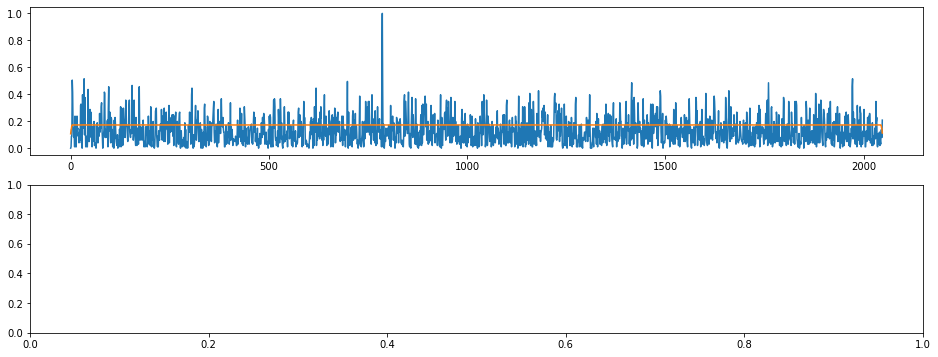

index:  111016
MAE:  0.09225262520056099
n_bunches       1092
bunch_index      175
bunch_number     131
Name: 7221279, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6602/instability_data/06602_Inst_B1H_Q7_20180423_17h08m15s.h5


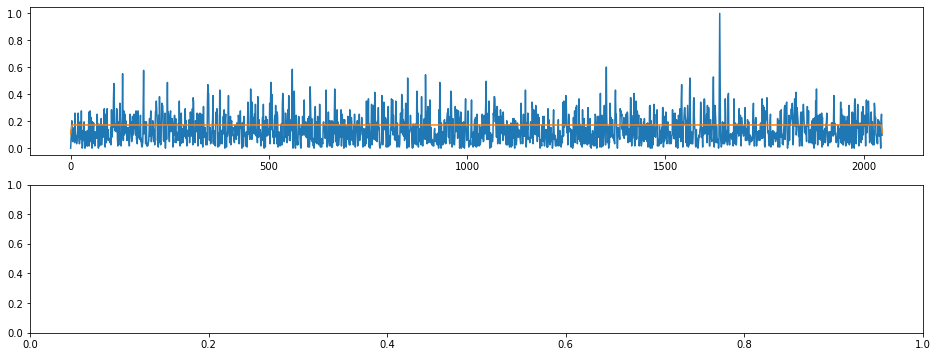

index:  294669
MAE:  0.09233809173070598
n_bunches       1068
bunch_index      641
bunch_number     457
Name: 8577353, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6774/instability_data/06774_Inst_B1H_Q7_20180610_22h52m15s.h5


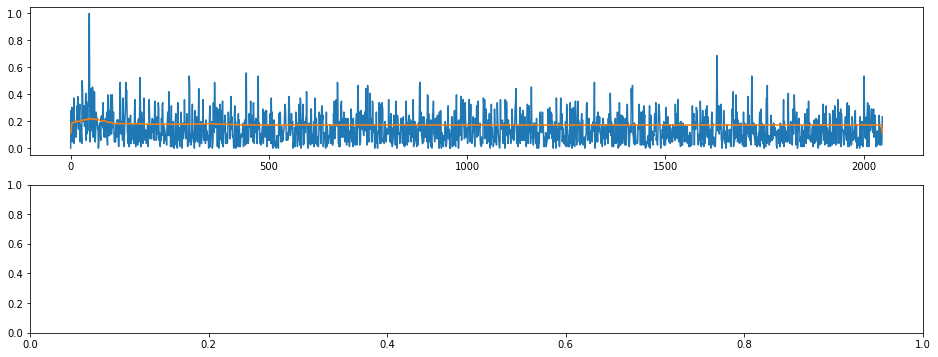

index:  263103
MAE:  0.09238718008450782
n_bunches       636
bunch_index     848
bunch_number    615
Name: 7822913, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7039/instability_data/07039_Inst_B1H_Q7_20180809_04h00m25s.h5


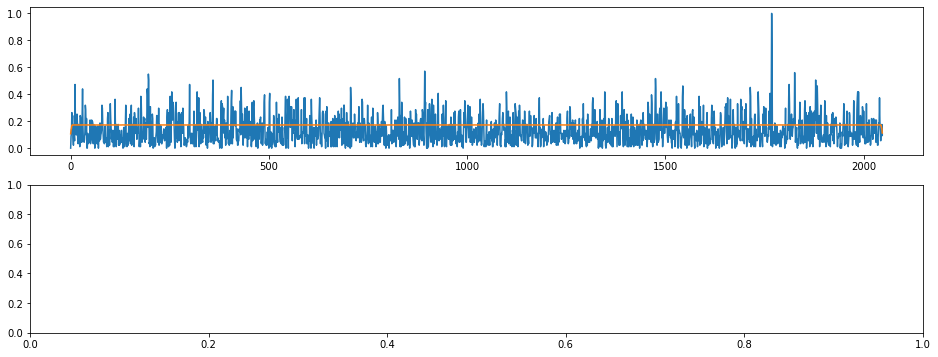

index:  361250
MAE:  0.0924698744648233
n_bunches       2556
bunch_index      482
bunch_number     343
Name: 5613816, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7033/instability_data/07033_Inst_B1H_Q7_20180807_10h07m15s.h5


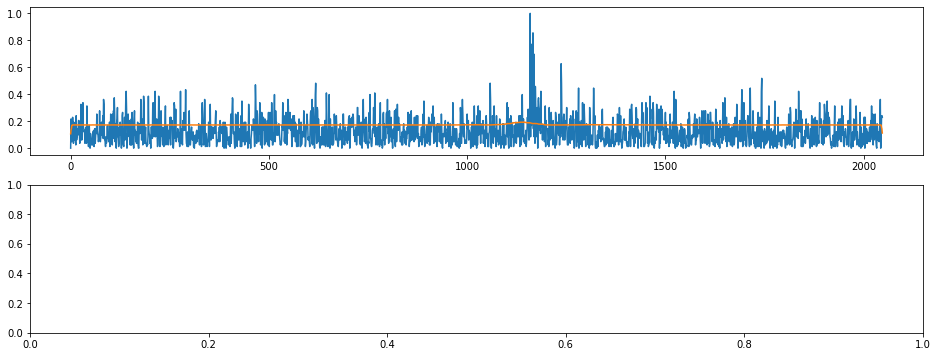

index:  222020
MAE:  0.09247889805647949
n_bunches       2556
bunch_index     2722
bunch_number    1995
Name: 9324565, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_04h31m14s.h5


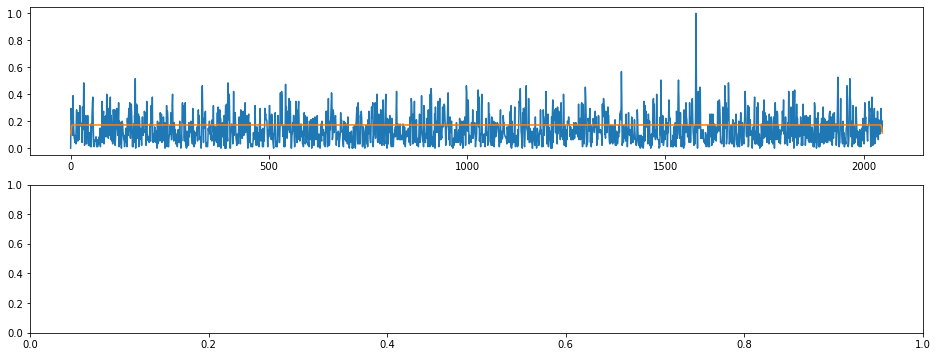

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  173407
MAE:  0.1330382537266256
n_bunches       780
bunch_index      20
bunch_number      2
Name: 10631246, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6961/instability_data/06961_Inst_B1H_Q7_20180722_19h29m30s.h5


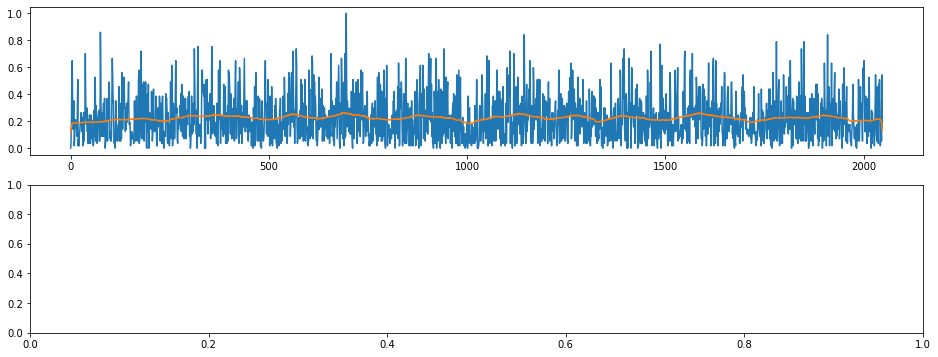

index:  267992
MAE:  0.13303827939304758
n_bunches        339
bunch_index     2929
bunch_number     323
Name: 7144597, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6594/instability_data/06594_Inst_B1H_Q7_20180422_17h55m14s.h5


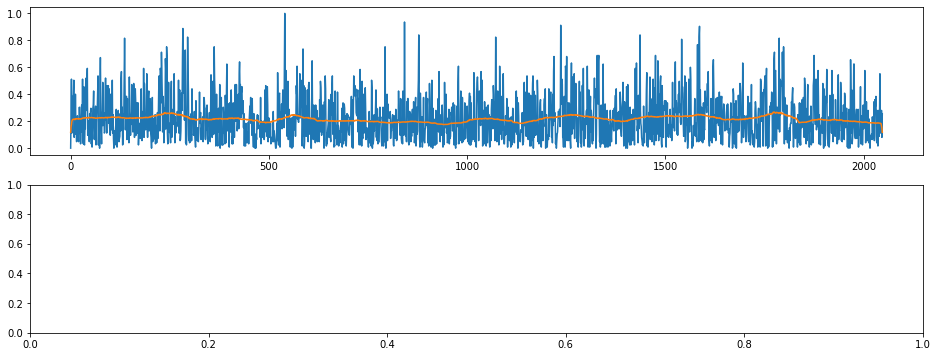

index:  92950
MAE:  0.1330382884760945
n_bunches        355
bunch_index     1137
bunch_number     236
Name: 8130331, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7467/instability_data/07467_Inst_B1H_Q7_20181123_08h41m14s.h5


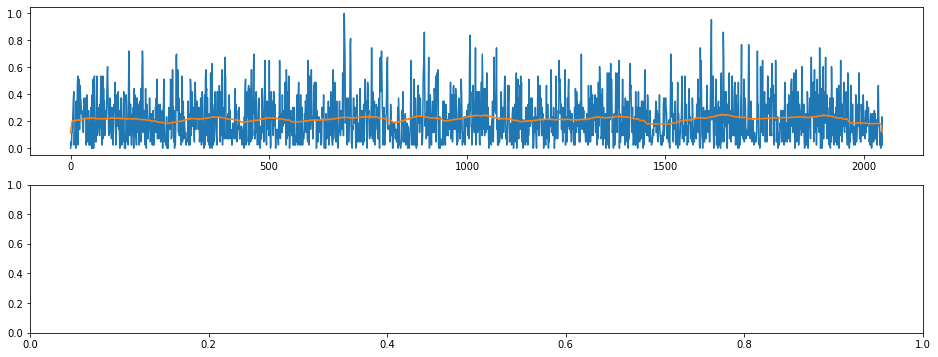

index:  267043
MAE:  0.13303813411093196
n_bunches       780
bunch_index     687
bunch_number    496
Name: 9351919, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6912/instability_data/06912_Inst_B1H_Q7_20180711_23h24m14s.h5


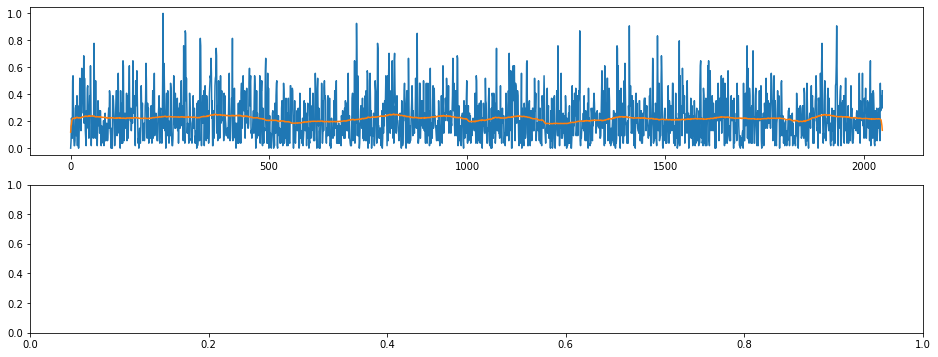

index:  146283
MAE:  0.13303811876782373
n_bunches        460
bunch_index     1576
bunch_number     210
Name: 11038500, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/instability_data/07464_Inst_B1H_Q7_20181122_04h42m14s.h5


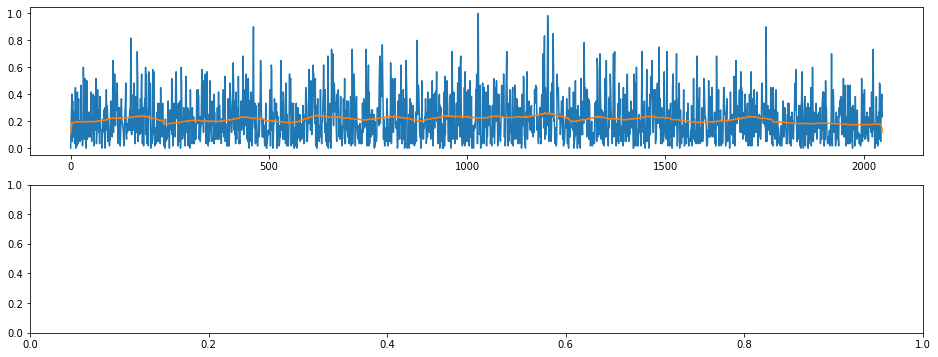

index:  216906
MAE:  0.13303807654218483
n_bunches       396
bunch_index     115
bunch_number     47
Name: 1985048, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6729/instability_data/06729_Inst_B1H_Q7_20180526_15h16m14s.h5


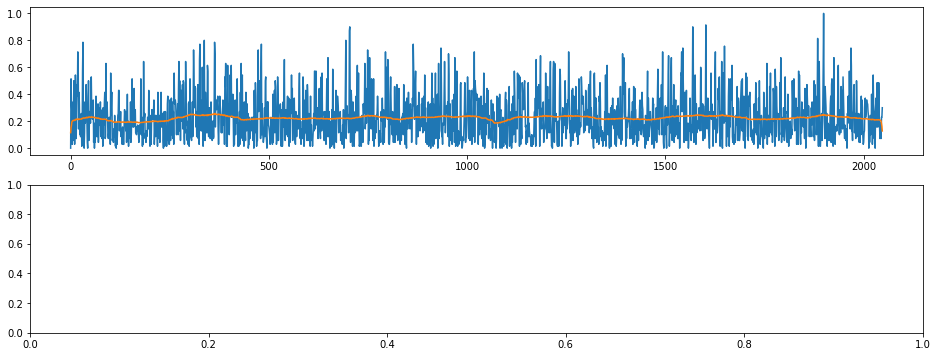

index:  294952
MAE:  0.1330383824679302
n_bunches       2556
bunch_index      155
bunch_number      99
Name: 3227470, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7137/instability_data/07137_Inst_B1H_Q7_20180908_04h59m14s.h5


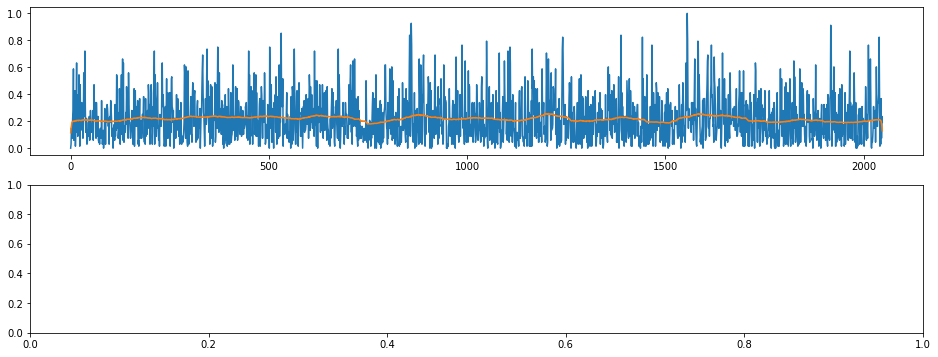

index:  137001
MAE:  0.13303841789968796
n_bunches       1212
bunch_index      855
bunch_number     622
Name: 5497533, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7234/instability_data/07234_Inst_B1H_Q7_20180929_02h45m57s.h5


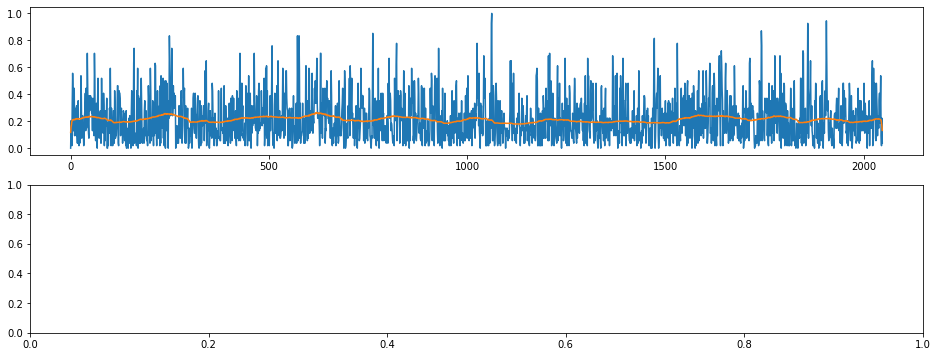

index:  374989
MAE:  0.13303843244960134
n_bunches       2175
bunch_index      966
bunch_number     594
Name: 6508446, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_14h51m14s.h5


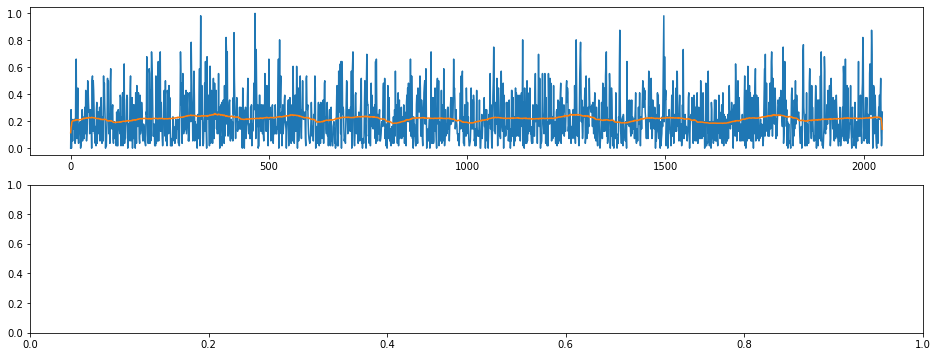

index:  70672
MAE:  0.13303779692954315
n_bunches        781
bunch_index     1298
bunch_number     778
Name: 3079057, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6629/instability_data/06629_Inst_B1H_Q7_20180501_11h03m21s.h5


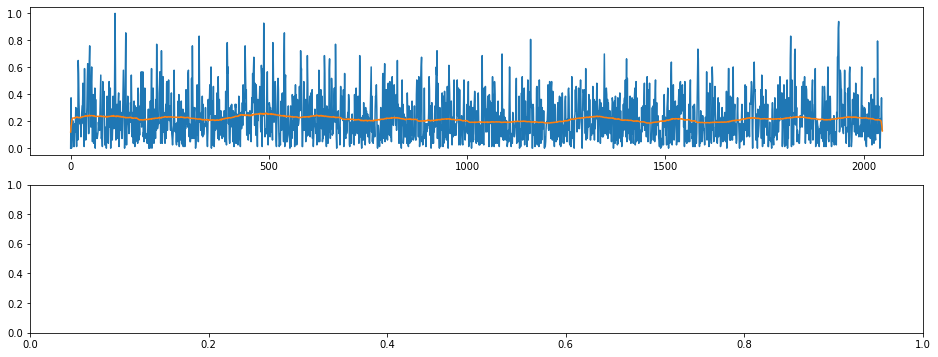

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  303992
MAE:  0.3086549503211008
n_bunches       2556
bunch_index     1072
bunch_number     775
Name: 5984987, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_06h25m14s.h5


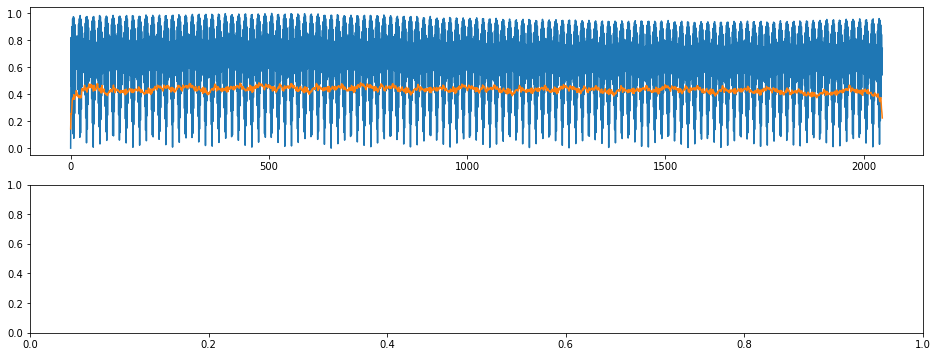

index:  304706
MAE:  0.30690072032504534
n_bunches       460
bunch_index     203
bunch_number     98
Name: 11657786, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h37m05s.h5


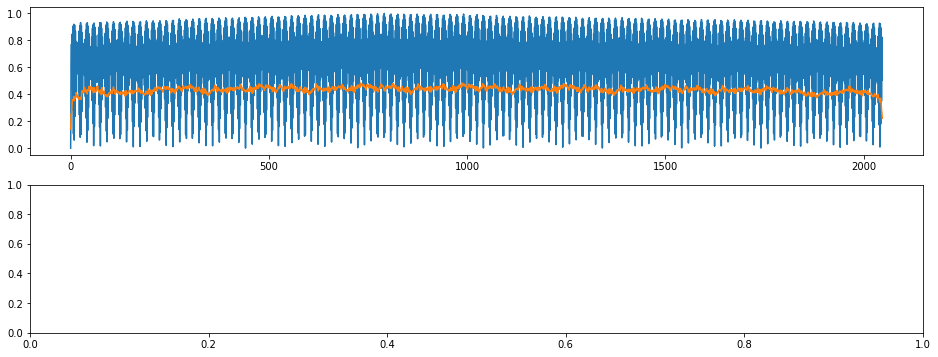

index:  402833
MAE:  0.2996689763172509
n_bunches       1916
bunch_index     3230
bunch_number    1794
Name: 3494424, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_08h45m15s.h5


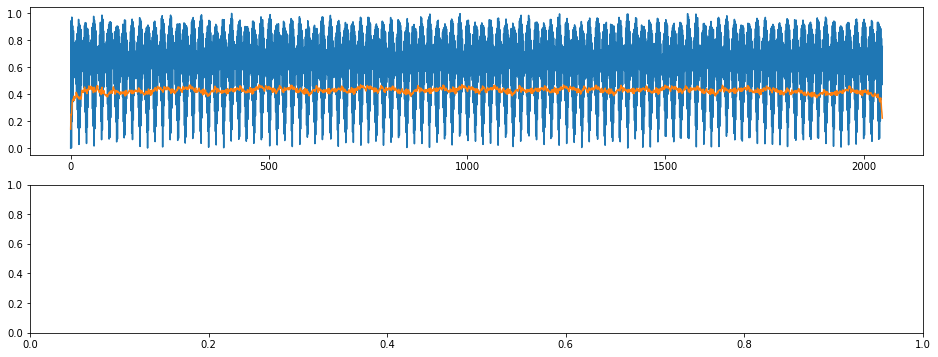

index:  402814
MAE:  0.2981678935017291
n_bunches       1916
bunch_index       87
bunch_number      37
Name: 10317612, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_00h23m15s.h5


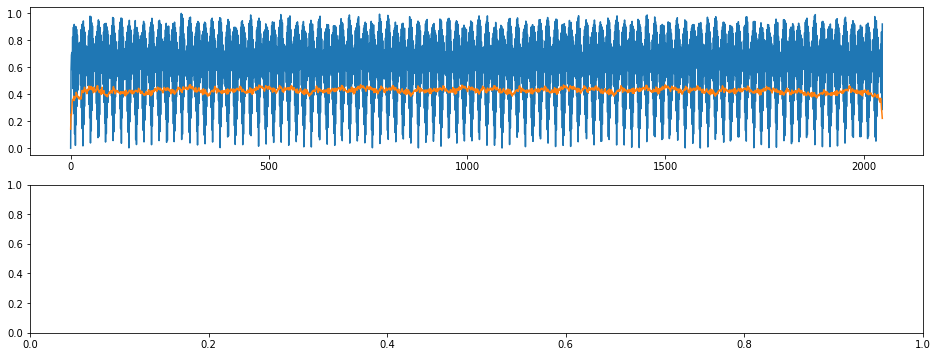

index:  407012
MAE:  0.29511578975452646
n_bunches       2460
bunch_index     1078
bunch_number     787
Name: 3625900, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6860/instability_data/06860_Inst_B1H_Q7_20180628_21h06m14s.h5


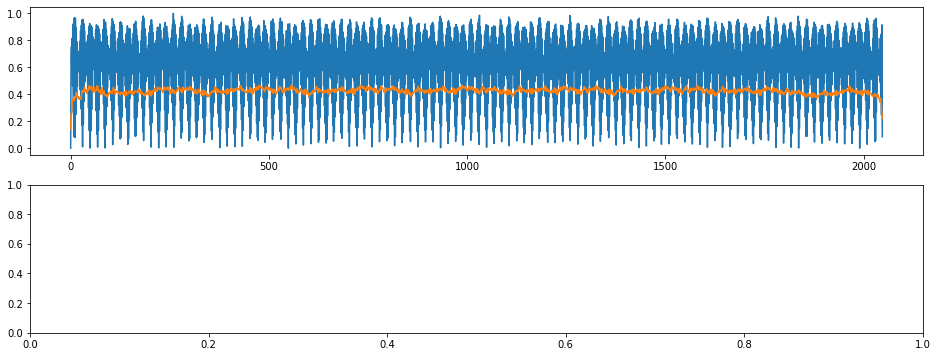

index:  306663
MAE:  0.28565129414596935
n_bunches       2556
bunch_index      821
bunch_number     588
Name: 3944765, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_23h30m14s.h5


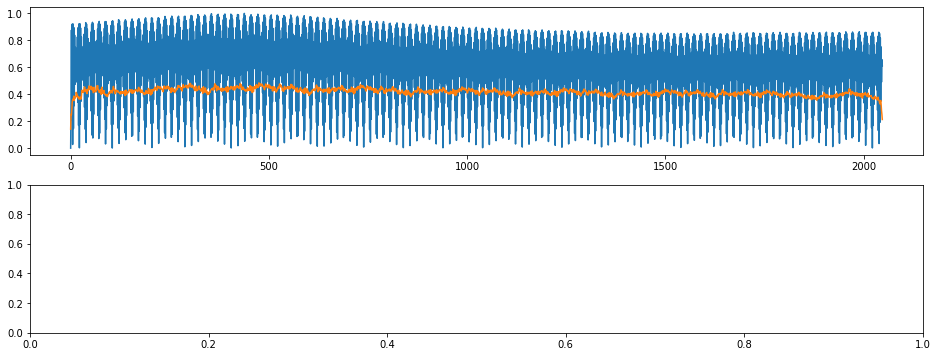

index:  278115
MAE:  0.275838904475578
n_bunches        924
bunch_index     1143
bunch_number     815
Name: 9468795, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_03h05m05s.h5


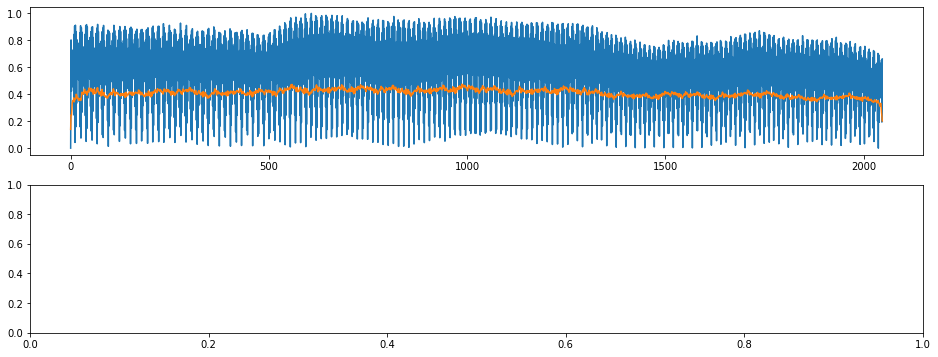

index:  386272
MAE:  0.2732793250717237
n_bunches       1551
bunch_index     2003
bunch_number     871
Name: 5515197, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180501_06h36m15s.h5


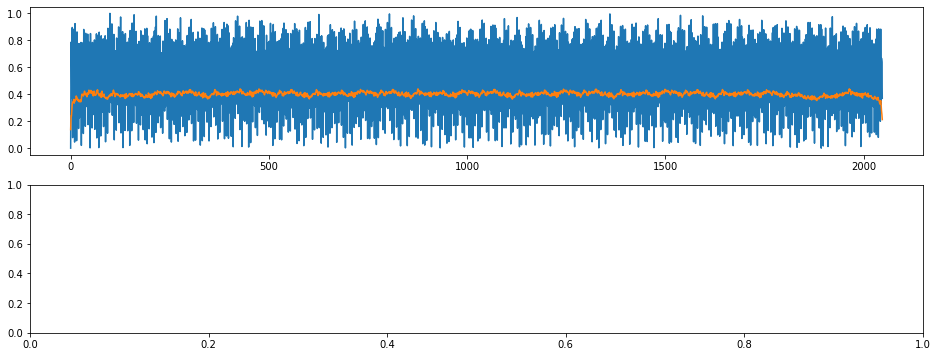

index:  406093
MAE:  0.27218627045589916
n_bunches       1452
bunch_index     1456
bunch_number     606
Name: 4570970, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180706_09h56m14s.h5


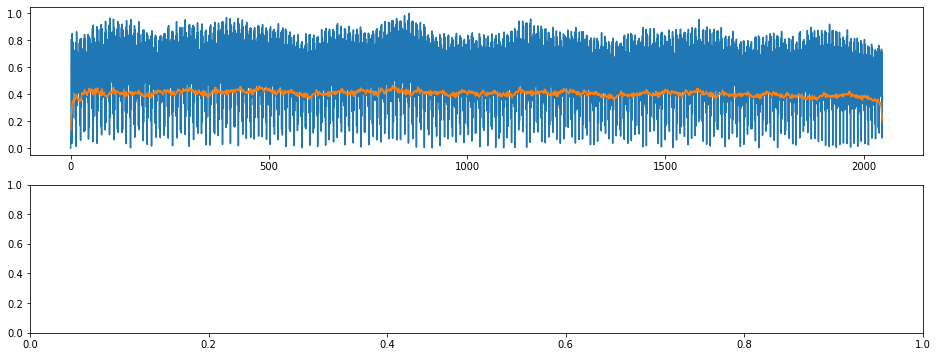

index:  388786
MAE:  0.2714875329570925
n_bunches       576
bunch_index     257
bunch_number     42
Name: 2634007, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7449/instability_data/07449_Inst_B1H_Q7_20181116_17h48m14s.h5


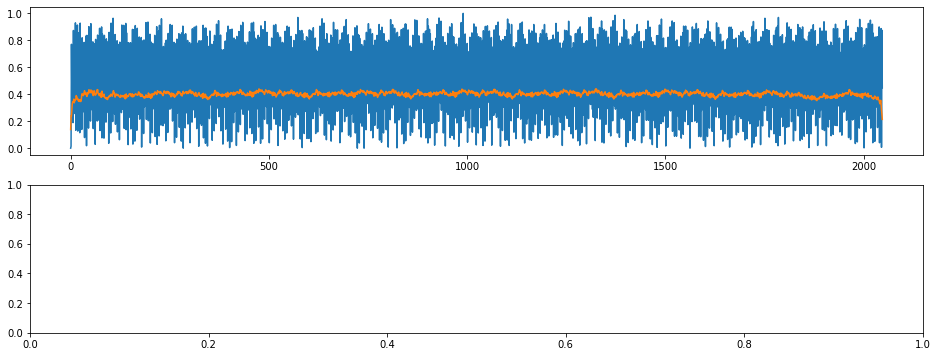

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_3').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 8, 8])

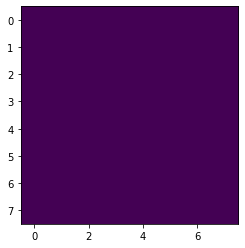

In [35]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  307589
MAE:  0.08913404150786977
n_bunches        648
bunch_index     1078
bunch_number     200
Name: 9999933, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_09h21m15s.h5


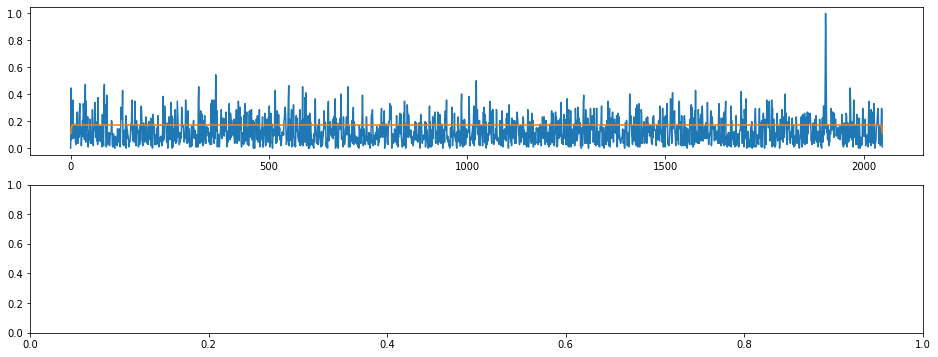

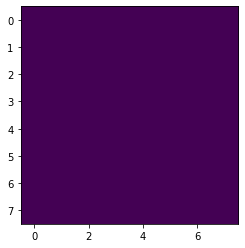

index:  306176
MAE:  0.0899495039493434
n_bunches       1836
bunch_index     2865
bunch_number    1531
Name: 7048207, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6268/instability_data/06268_Inst_B1H_Q7_20171003_13h28m22s.h5


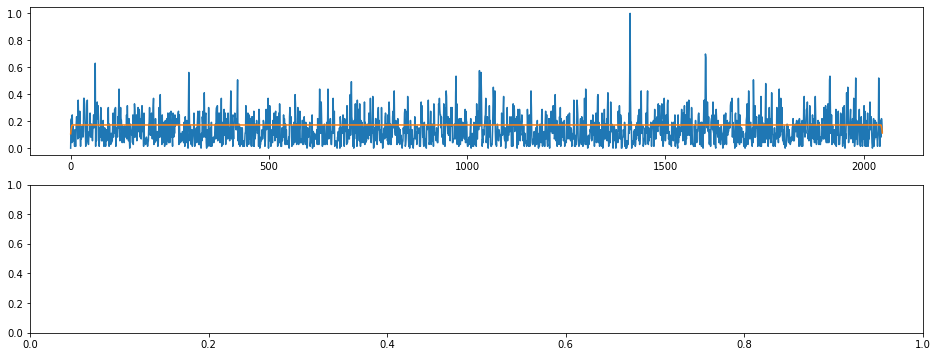

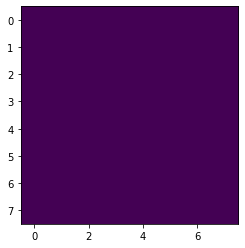

index:  204757
MAE:  0.09072664813084932
n_bunches       120
bunch_index     447
bunch_number     78
Name: 9159136, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7086/instability_data/07086_Inst_B1H_Q7_20180825_12h47m27s.h5


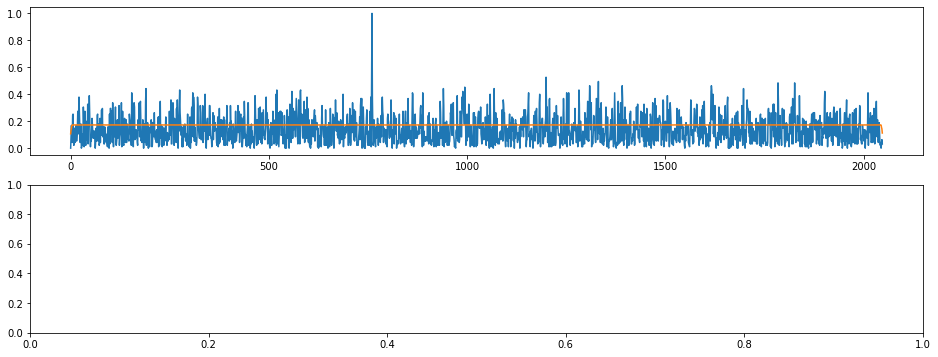

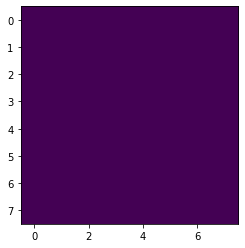

index:  298465
MAE:  0.09087737511156145
n_bunches       396
bunch_index      86
bunch_number     18
Name: 9130984, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6654/instability_data/06654_Inst_B1H_Q7_20180507_22h10m42s.h5


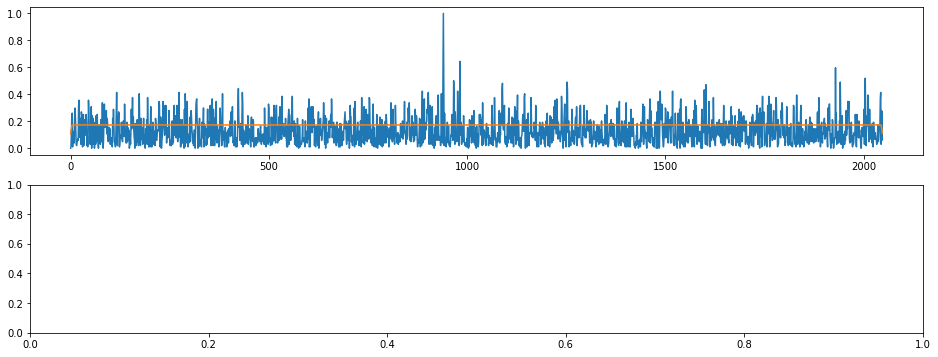

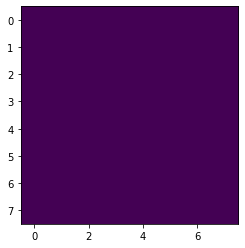

index:  55364
MAE:  0.09160739336444335
n_bunches       1004
bunch_index      583
bunch_number     307
Name: 5266075, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6360/instability_data/06360_Inst_B1H_Q7_20171103_13h16m48s.h5


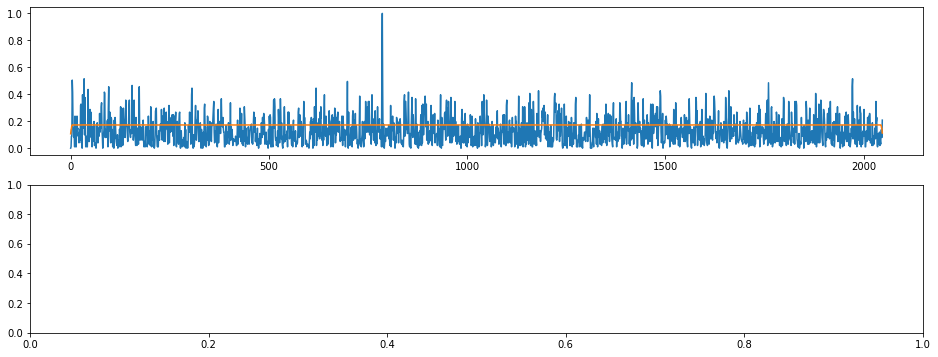

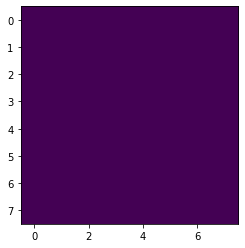

index:  111016
MAE:  0.09225262520056099
n_bunches       1092
bunch_index      175
bunch_number     131
Name: 7221279, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6602/instability_data/06602_Inst_B1H_Q7_20180423_17h08m15s.h5


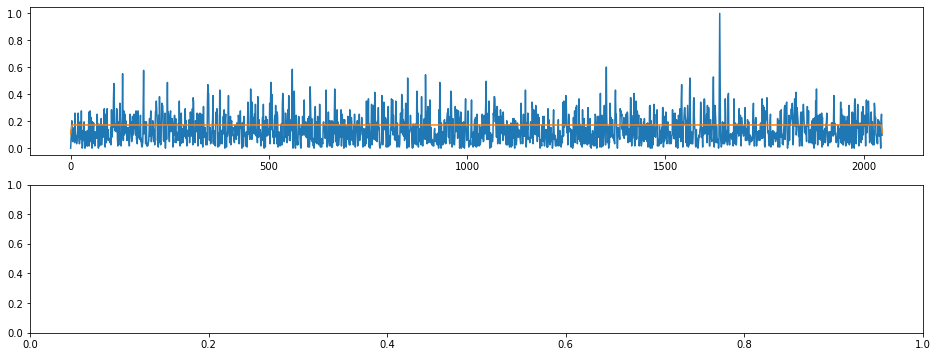

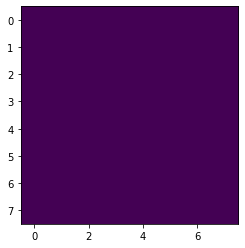

index:  294669
MAE:  0.09233809173070598
n_bunches       1068
bunch_index      641
bunch_number     457
Name: 8577353, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6774/instability_data/06774_Inst_B1H_Q7_20180610_22h52m15s.h5


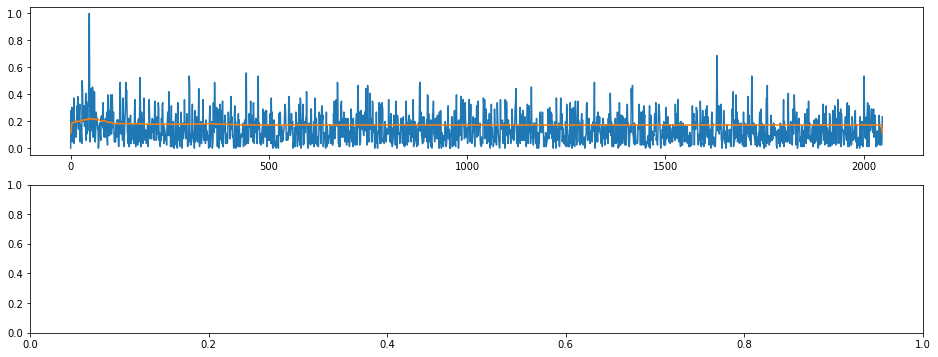

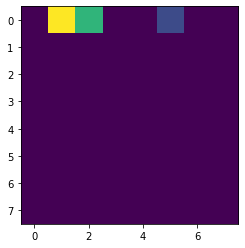

index:  263103
MAE:  0.09238718008450782
n_bunches       636
bunch_index     848
bunch_number    615
Name: 7822913, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7039/instability_data/07039_Inst_B1H_Q7_20180809_04h00m25s.h5


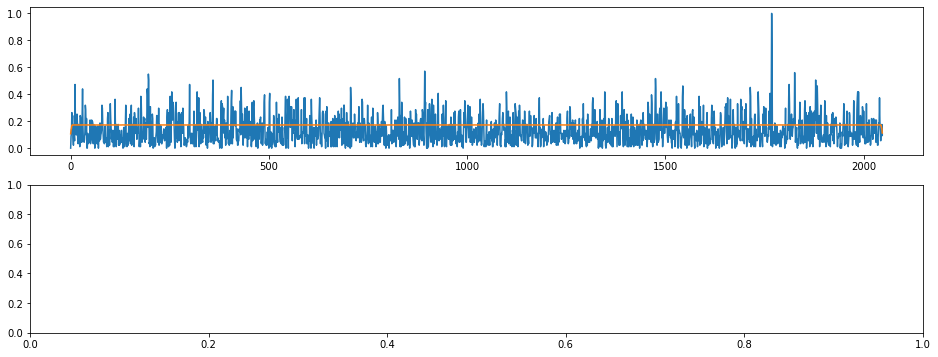

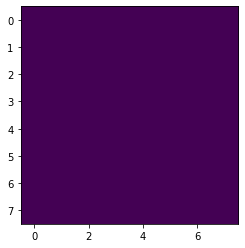

index:  361250
MAE:  0.0924698744648233
n_bunches       2556
bunch_index      482
bunch_number     343
Name: 5613816, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7033/instability_data/07033_Inst_B1H_Q7_20180807_10h07m15s.h5


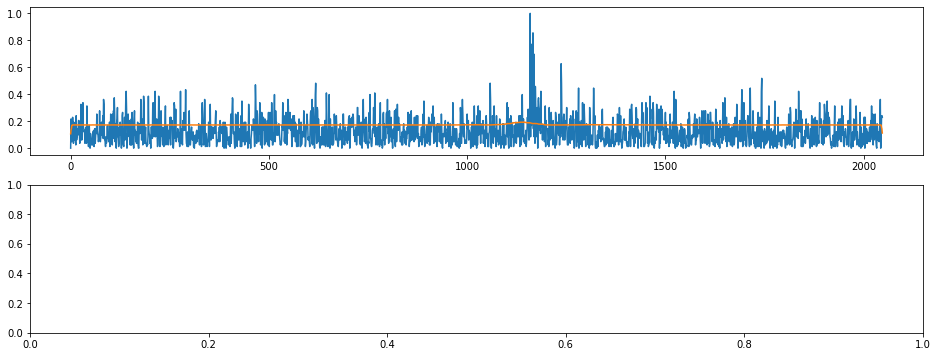

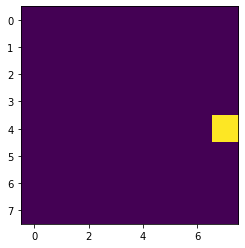

index:  222020
MAE:  0.09247889805647949
n_bunches       2556
bunch_index     2722
bunch_number    1995
Name: 9324565, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_04h31m14s.h5


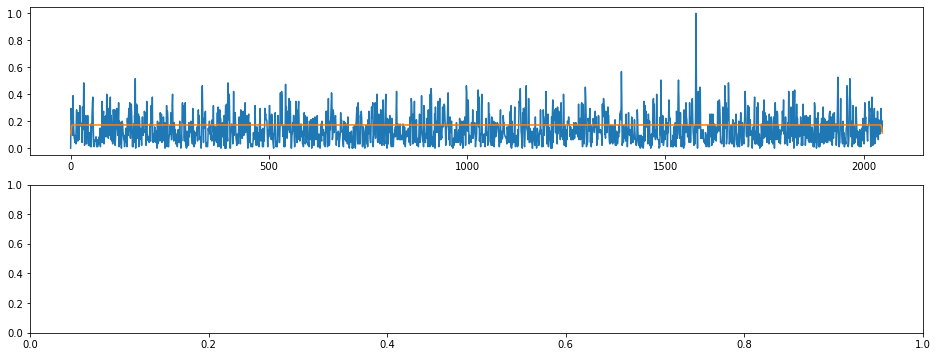

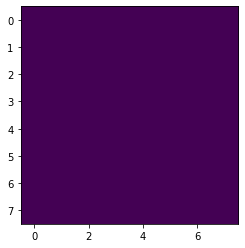

In [36]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  303992
MAE:  0.3086549503211008
n_bunches       2556
bunch_index     1072
bunch_number     775
Name: 5984987, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_06h25m14s.h5


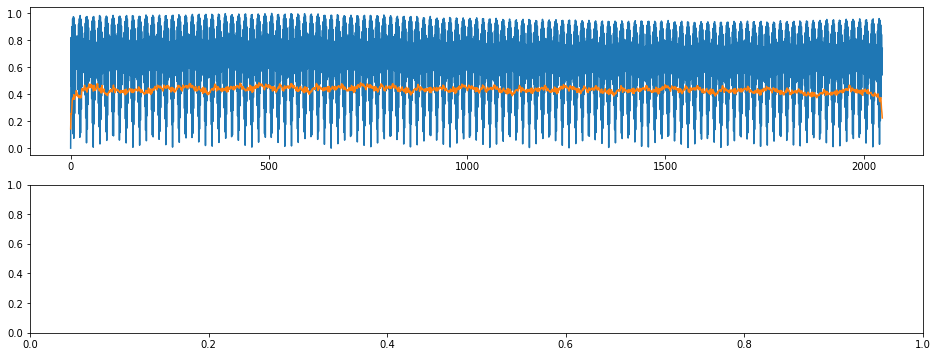

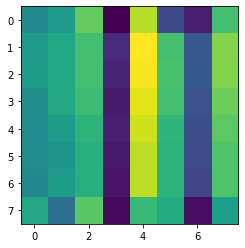

index:  304706
MAE:  0.30690072032504534
n_bunches       460
bunch_index     203
bunch_number     98
Name: 11657786, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h37m05s.h5


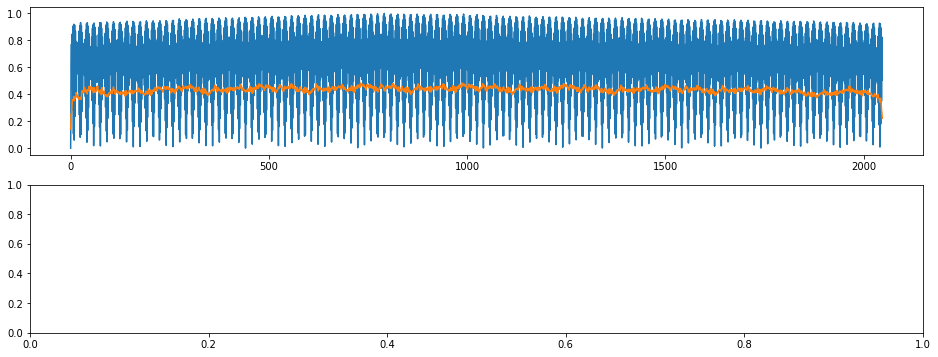

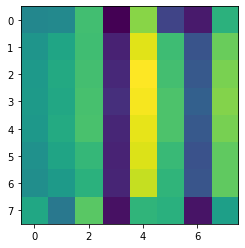

index:  402833
MAE:  0.2996689763172509
n_bunches       1916
bunch_index     3230
bunch_number    1794
Name: 3494424, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_08h45m15s.h5


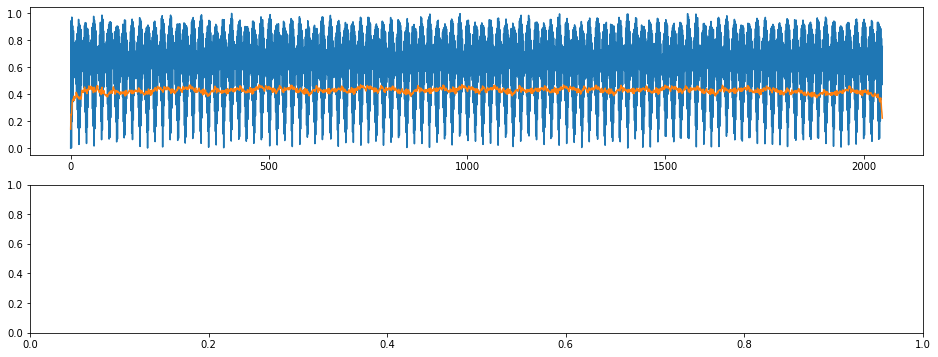

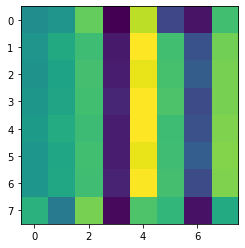

index:  402814
MAE:  0.2981678935017291
n_bunches       1916
bunch_index       87
bunch_number      37
Name: 10317612, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_00h23m15s.h5


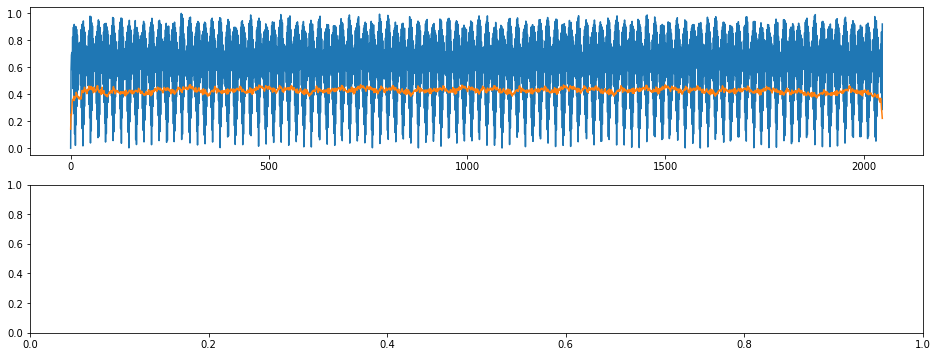

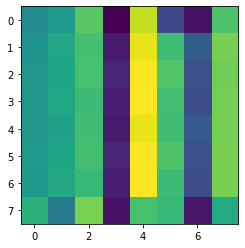

index:  407012
MAE:  0.29511578975452646
n_bunches       2460
bunch_index     1078
bunch_number     787
Name: 3625900, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6860/instability_data/06860_Inst_B1H_Q7_20180628_21h06m14s.h5


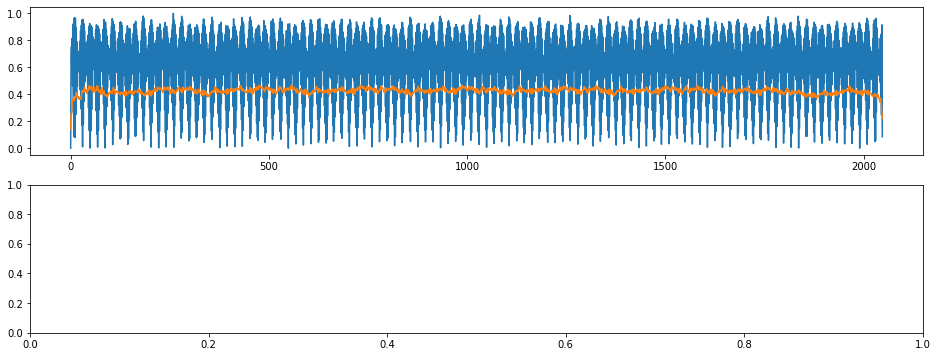

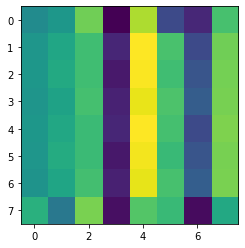

index:  306663
MAE:  0.28565129414596935
n_bunches       2556
bunch_index      821
bunch_number     588
Name: 3944765, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_23h30m14s.h5


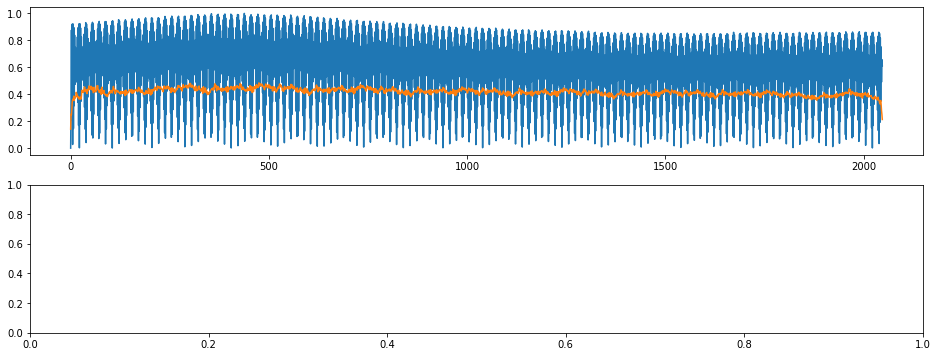

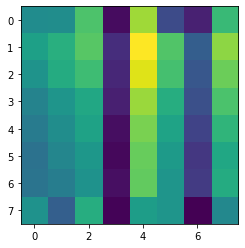

index:  278115
MAE:  0.275838904475578
n_bunches        924
bunch_index     1143
bunch_number     815
Name: 9468795, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_03h05m05s.h5


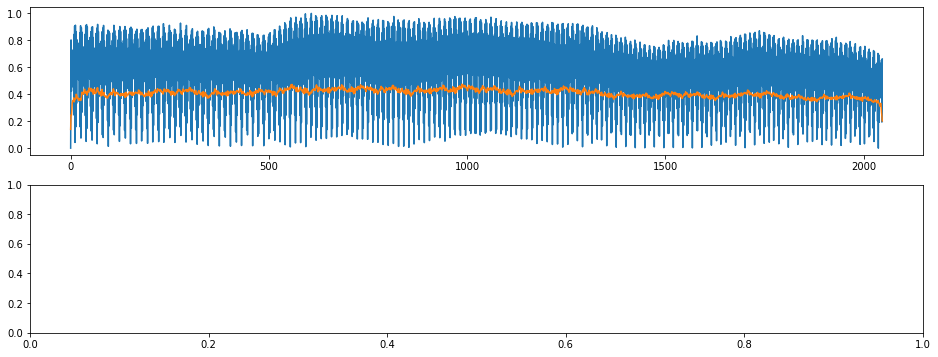

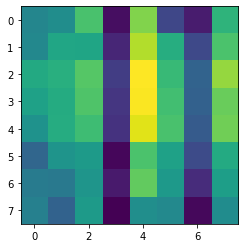

index:  386272
MAE:  0.2732793250717237
n_bunches       1551
bunch_index     2003
bunch_number     871
Name: 5515197, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180501_06h36m15s.h5


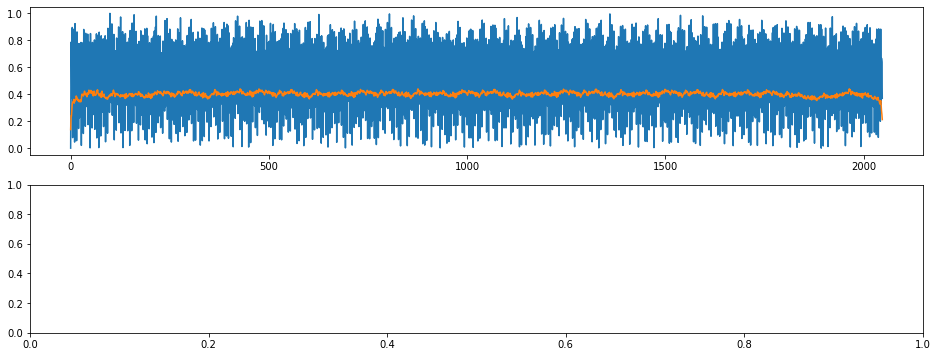

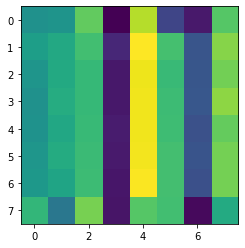

index:  406093
MAE:  0.27218627045589916
n_bunches       1452
bunch_index     1456
bunch_number     606
Name: 4570970, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180706_09h56m14s.h5


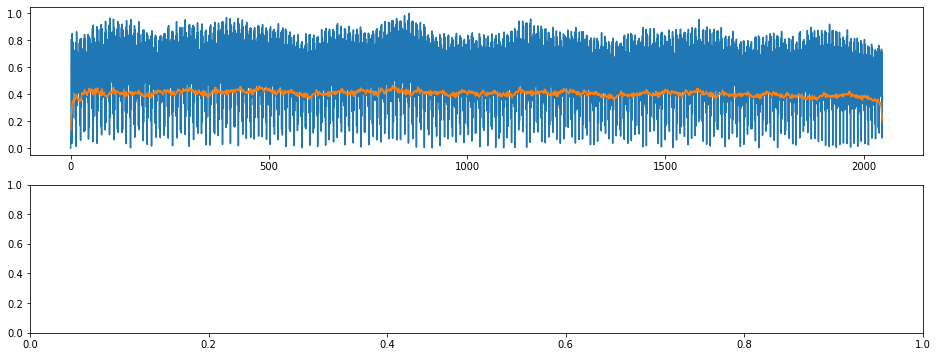

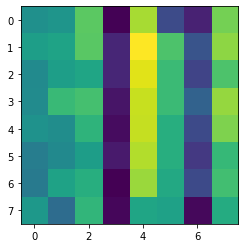

index:  388786
MAE:  0.2714875329570925
n_bunches       576
bunch_index     257
bunch_number     42
Name: 2634007, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7449/instability_data/07449_Inst_B1H_Q7_20181116_17h48m14s.h5


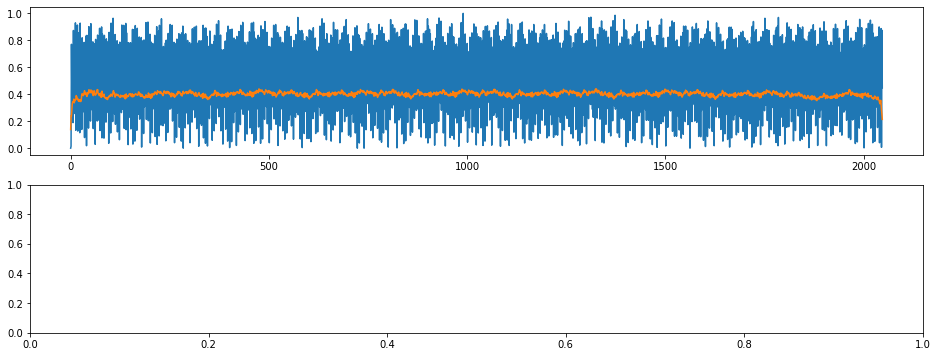

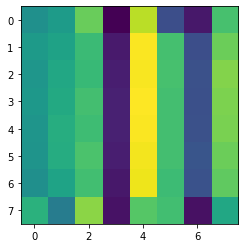

index:  247639
MAE:  0.26942933429717625
n_bunches       252
bunch_index     158
bunch_number    102
Name: 3698950, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7320/instability_data/07320_Inst_B1H_Q7_20181019_15h37m49s.h5


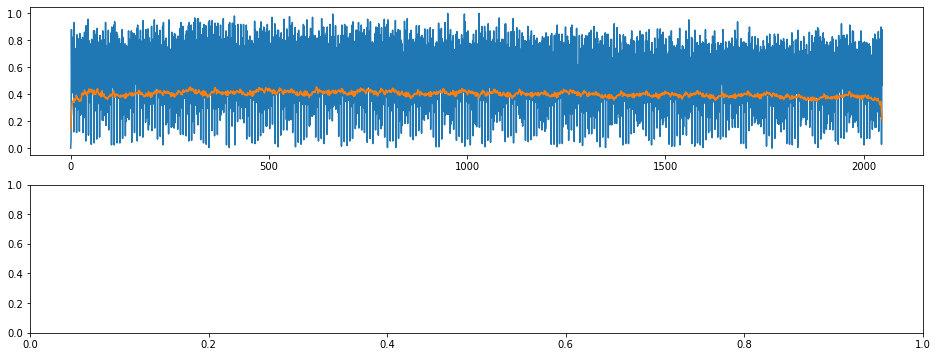

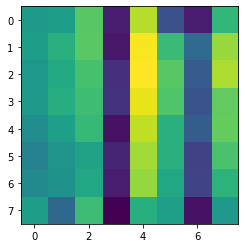

index:  389382
MAE:  0.2678759647473714
n_bunches       1227
bunch_index     1088
bunch_number     359
Name: 8153525, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_06h00m14s.h5


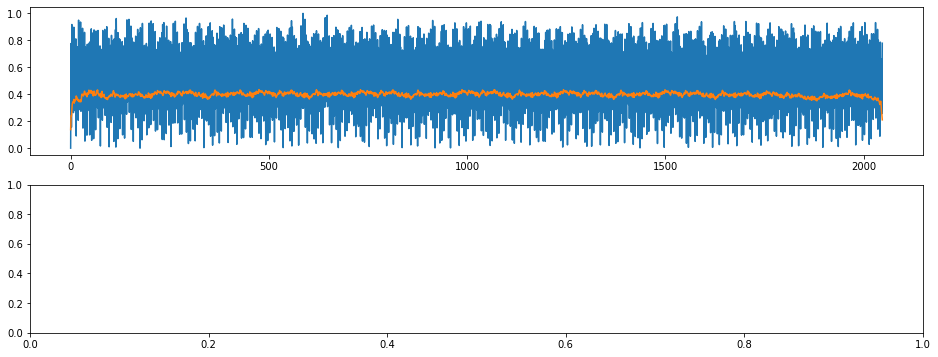

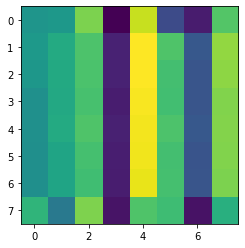

index:  291703
MAE:  0.26766003002746647
n_bunches       24
bunch_index     10
bunch_number    10
Name: 6772009, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6897/instability_data/06897_Inst_B1H_Q7_20180708_00h28m15s.h5


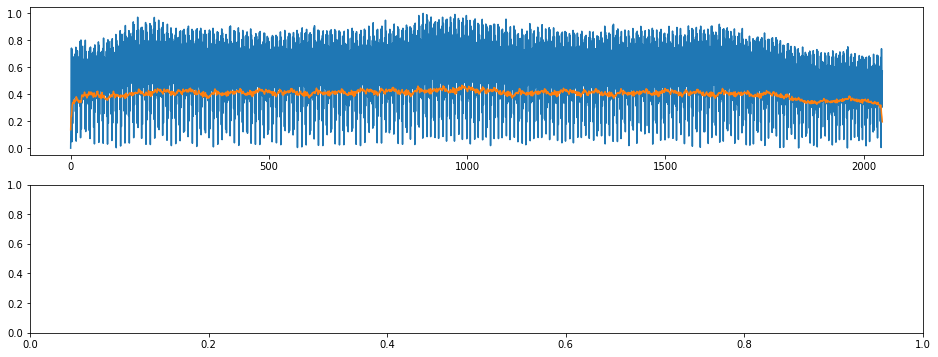

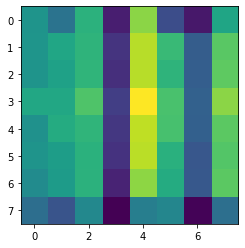

index:  252866
MAE:  0.2667226558701281
n_bunches       924
bunch_index     986
bunch_number    696
Name: 8177670, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6712/instability_data/06712_Inst_B1H_Q7_20180522_17h36m15s.h5


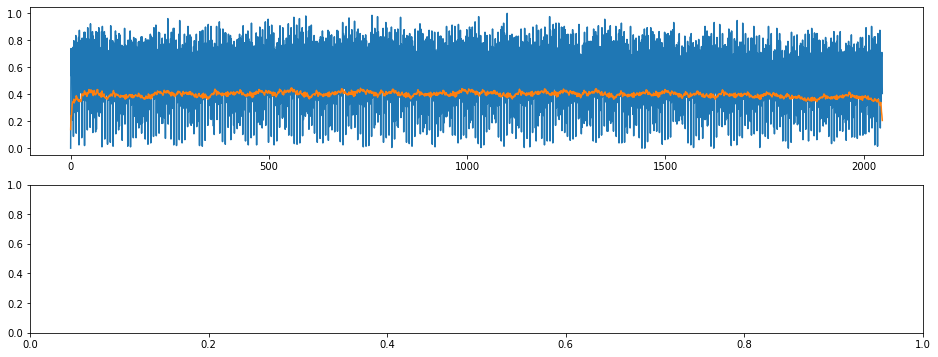

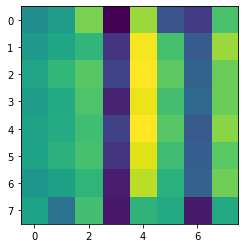

index:  175912
MAE:  0.2660978051426355
n_bunches       1868
bunch_index     2028
bunch_number    1090
Name: 8316764, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6348/instability_data/06348_Inst_B1H_Q7_20171030_21h11m14s.h5


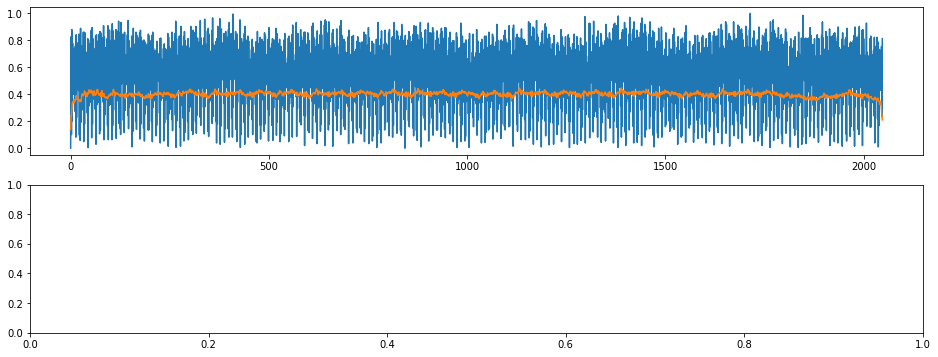

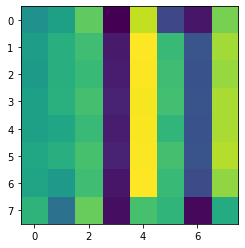

index:  286773
MAE:  0.2660640808550252
n_bunches       2556
bunch_index      537
bunch_number     391
Name: 11304379, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7058/instability_data/07058_Inst_B1H_Q7_20180817_18h33m15s.h5


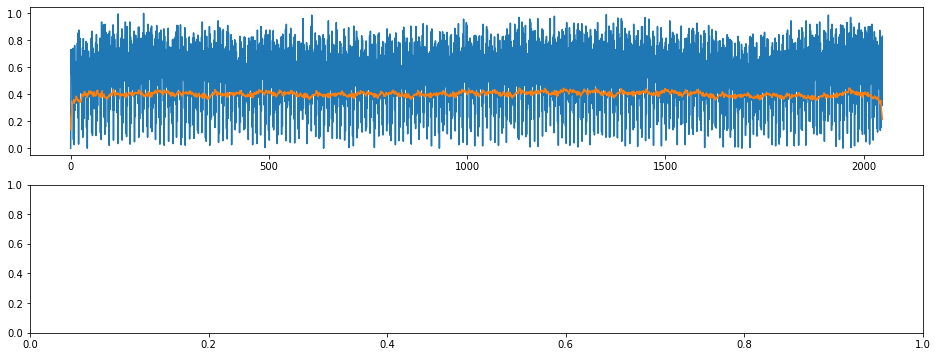

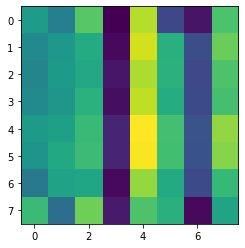

index:  336764
MAE:  0.2655814163881275
n_bunches       1068
bunch_index      216
bunch_number     129
Name: 282541, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7017/instability_data/07017_Inst_B1H_Q7_20180803_08h09m18s.h5


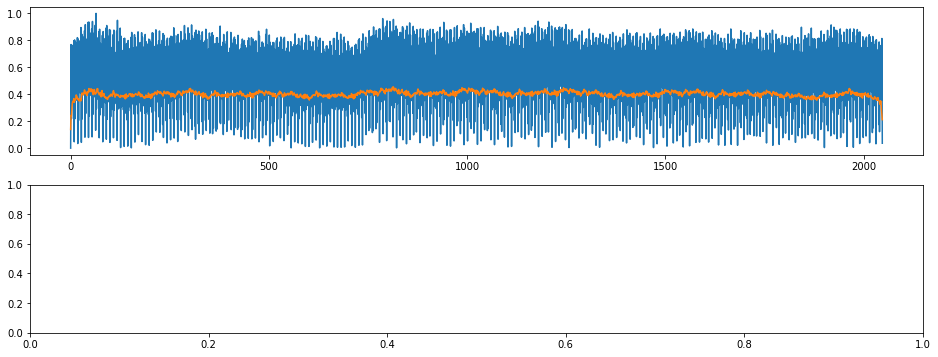

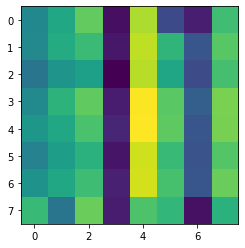

index:  179867
MAE:  0.2655315804728974
n_bunches        987
bunch_index     3037
bunch_number     884
Name: 7265555, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6616/instability_data/06616_Inst_B1H_Q7_20180427_11h45m13s.h5


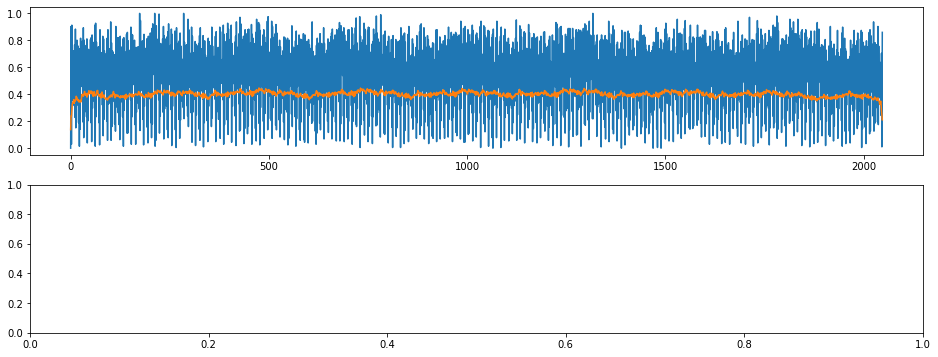

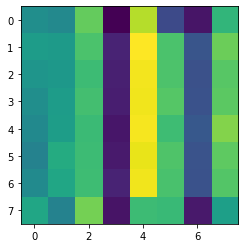

index:  214913
MAE:  0.26511054364286235
n_bunches       1868
bunch_index     1464
bunch_number     786
Name: 10698230, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6364/instability_data/06364_Inst_B1H_Q7_20171107_01h41m14s.h5


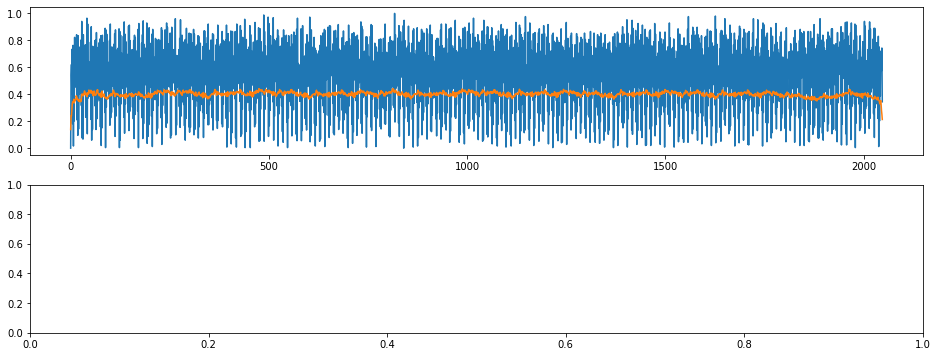

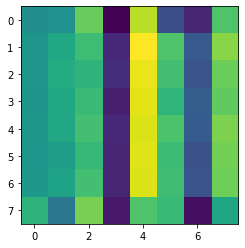

index:  249502
MAE:  0.2648323061248219
n_bunches       636
bunch_index     406
bunch_number    274
Name: 3970356, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7017/instability_data/07017_Inst_B1H_Q7_20180803_08h07m14s.h5


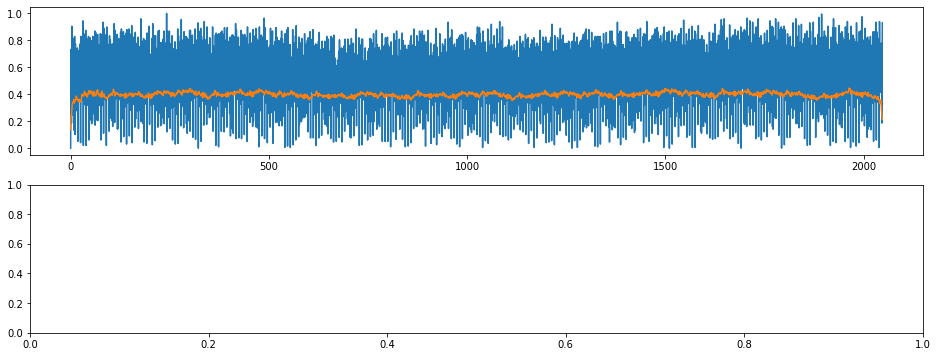

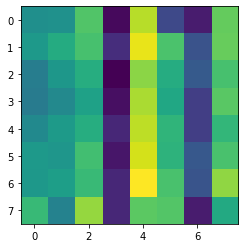

index:  175466
MAE:  0.26469330861762586
n_bunches       1068
bunch_index      591
bunch_number     414
Name: 3873859, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7039/instability_data/07039_Inst_B1H_Q7_20180809_04h03m13s.h5


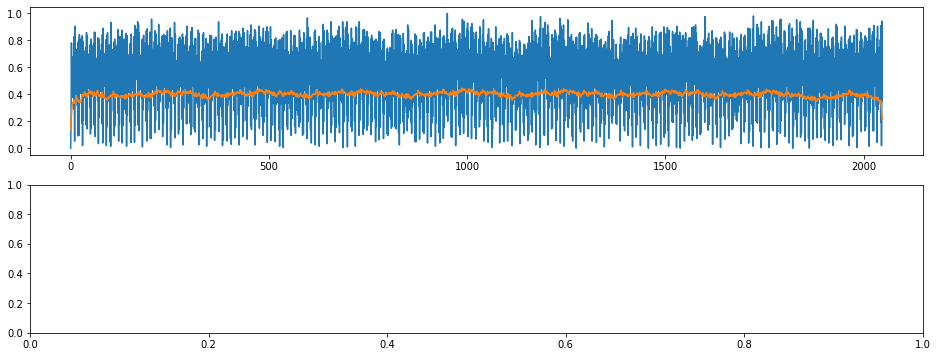

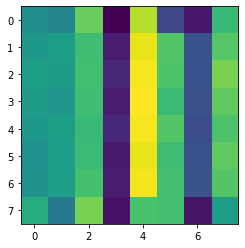

index:  172123
MAE:  0.26457105146158333
n_bunches       924
bunch_index     773
bunch_number    547
Name: 2537464, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6960/instability_data/06960_Inst_B1H_Q7_20180722_08h05m25s.h5


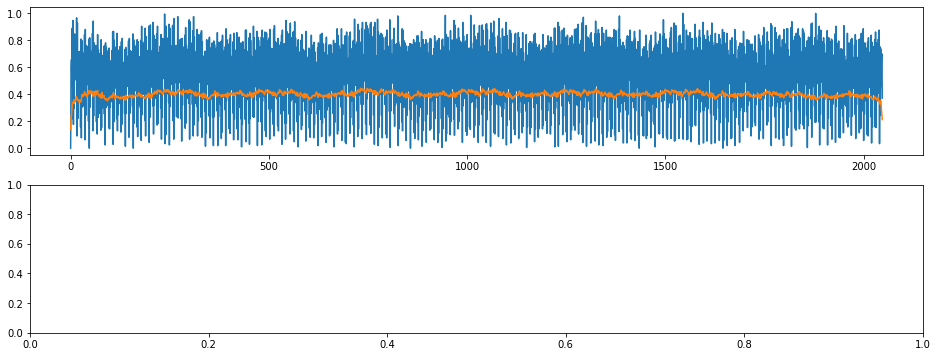

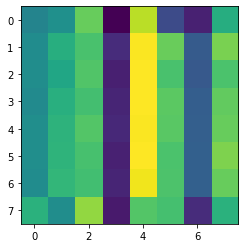

index:  106056
MAE:  0.2636372216458602
n_bunches       1868
bunch_index      376
bunch_number     192
Name: 1507110, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_04h12m14s.h5


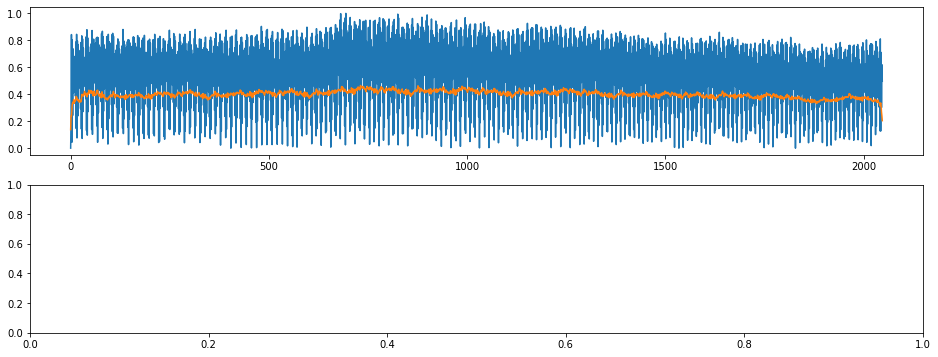

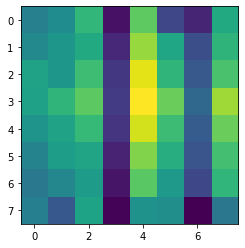

index:  248307
MAE:  0.2633289383492824
n_bunches       1916
bunch_index     2060
bunch_number    1132
Name: 8479001, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_03h50m14s.h5


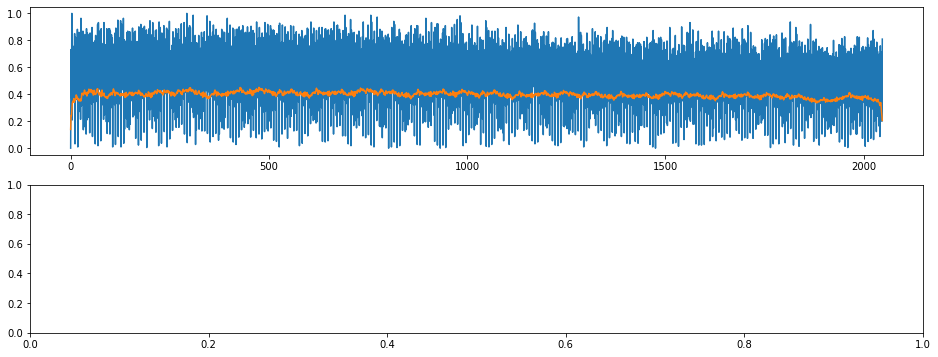

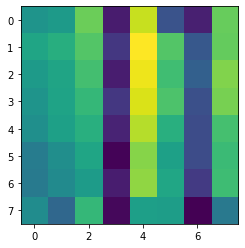

index:  174872
MAE:  0.2632764036573533
n_bunches       187
bunch_index     625
bunch_number    129
Name: 9280399, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7485/instability_data/07485_Inst_B1H_Q7_20181129_19h37m14s.h5


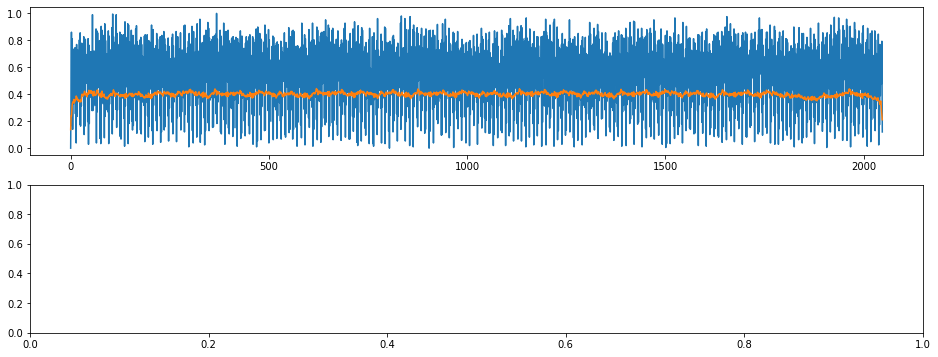

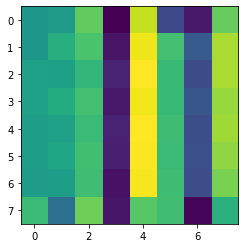

index:  98916
MAE:  0.2631726879196163
n_bunches        61
bunch_index     245
bunch_number     58
Name: 7974408, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6217/instability_data/06217_Inst_B1H_Q7_20170917_10h24m20s.h5


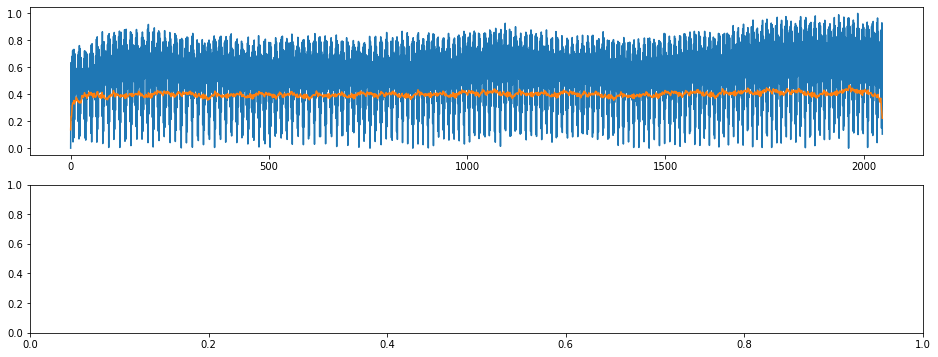

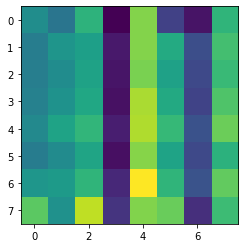

index:  249688
MAE:  0.26305495934616885
n_bunches       144
bunch_index     623
bunch_number    105
Name: 10276086, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7349/instability_data/07349_Inst_B1H_Q7_20181025_14h24m55s.h5


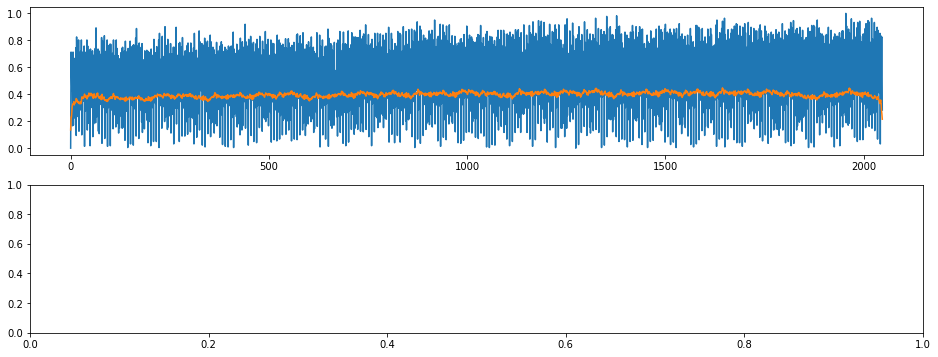

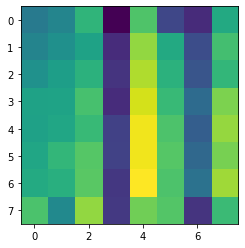

index:  175154
MAE:  0.2625167954505535
n_bunches       108
bunch_index      19
bunch_number      7
Name: 10068832, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h09m43s.h5


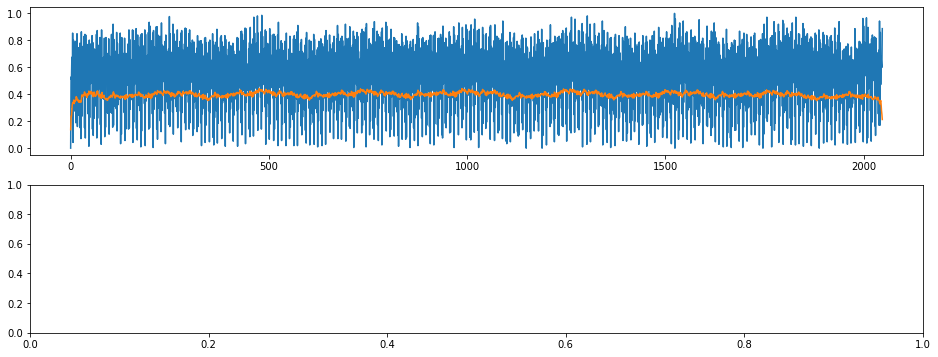

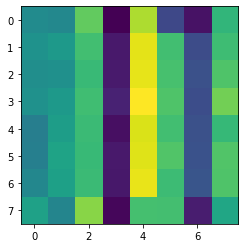

index:  178696
MAE:  0.26219463414613486
n_bunches       924
bunch_index     933
bunch_number    669
Name: 693103, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7314/instability_data/07314_Inst_B1H_Q7_20181017_23h24m42s.h5


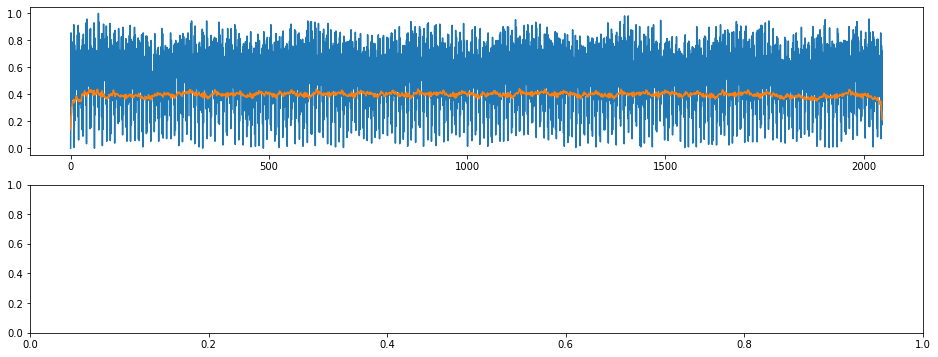

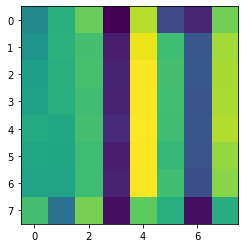

index:  251895
MAE:  0.26209177915351883
n_bunches       2556
bunch_index     2723
bunch_number    1996
Name: 6458107, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6762/instability_data/06762_Inst_B1H_Q7_20180606_12h50m16s.h5


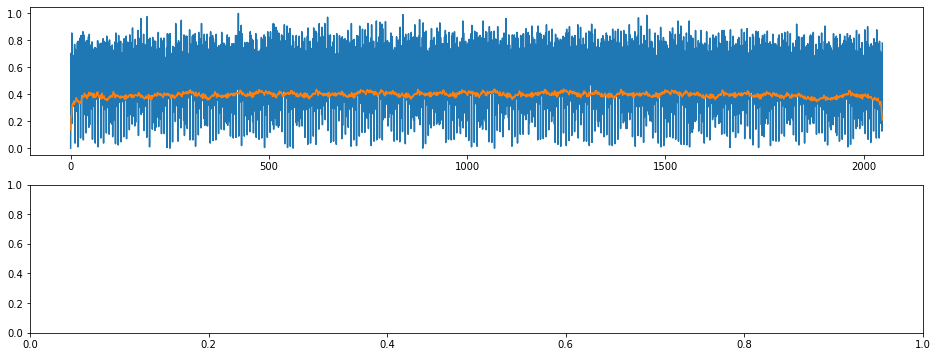

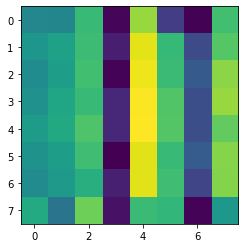

index:  215377
MAE:  0.26207174631961305
n_bunches       780
bunch_index     283
bunch_number    170
Name: 8899360, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6752/instability_data/06752_Inst_B1H_Q7_20180602_11h32m15s.h5


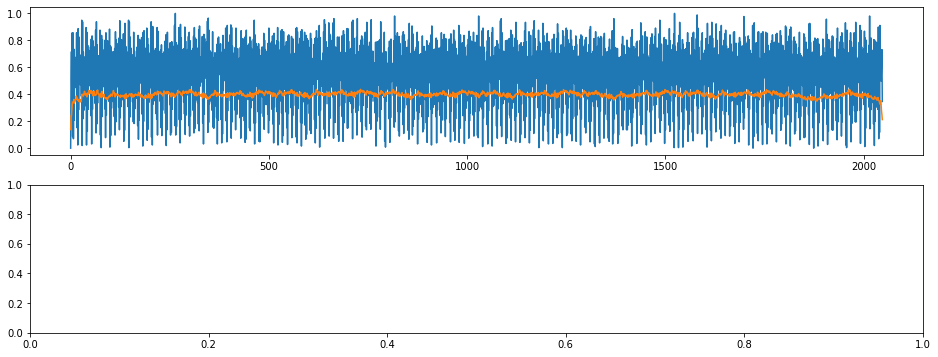

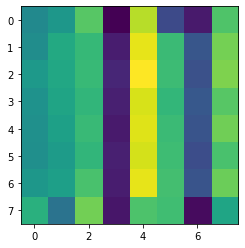

index:  178799
MAE:  0.26181101538436746
n_bunches       648
bunch_index      69
bunch_number      6
Name: 9179072, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_04h40m14s.h5


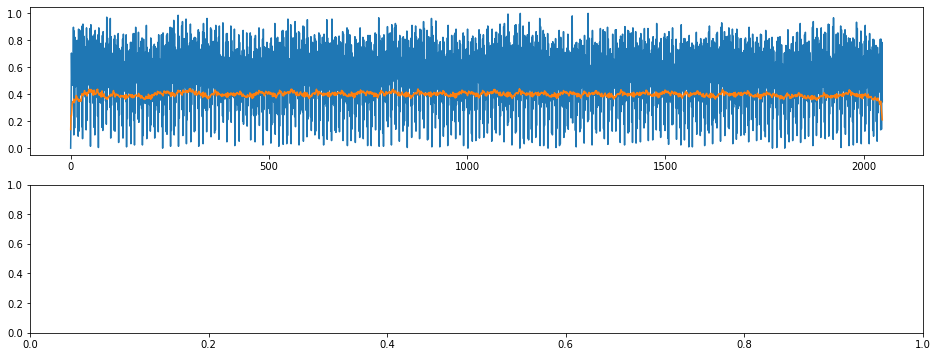

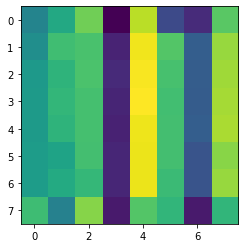

index:  246982
MAE:  0.2611466313145049
n_bunches       540
bunch_index     637
bunch_number    453
Name: 8396411, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7142/instability_data/07142_Inst_B1H_Q7_20180909_09h30m59s.h5


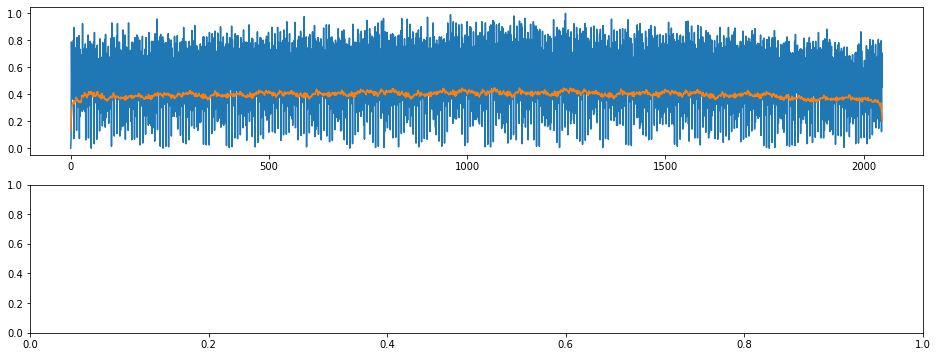

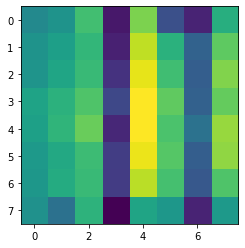

index:  98680
MAE:  0.2607457007196884
n_bunches       276
bunch_index      53
bunch_number     17
Name: 9271170, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7229/instability_data/07229_Inst_B1H_Q7_20180928_08h02m14s.h5


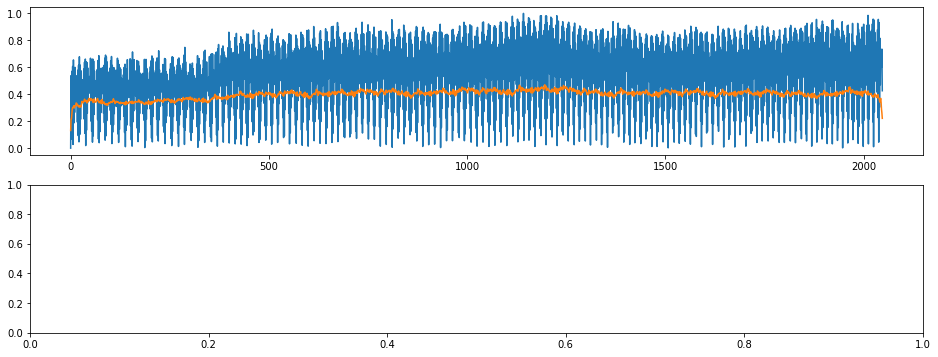

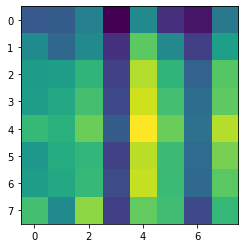

index:  105318
MAE:  0.2607063265326106
n_bunches        339
bunch_index     2789
bunch_number     288
Name: 5503325, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6594/instability_data/06594_Inst_B1H_Q7_20180422_12h50m14s.h5


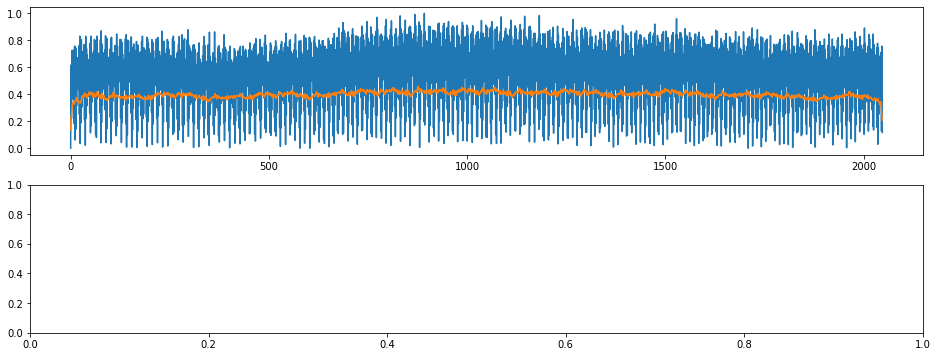

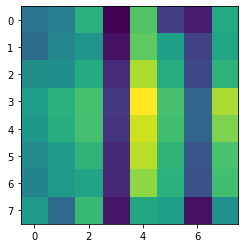

index:  178747
MAE:  0.26055091398851593
n_bunches       252
bunch_index      86
bunch_number     37
Name: 7855835, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7040/instability_data/07040_Inst_B1H_Q7_20180809_19h08m13s.h5


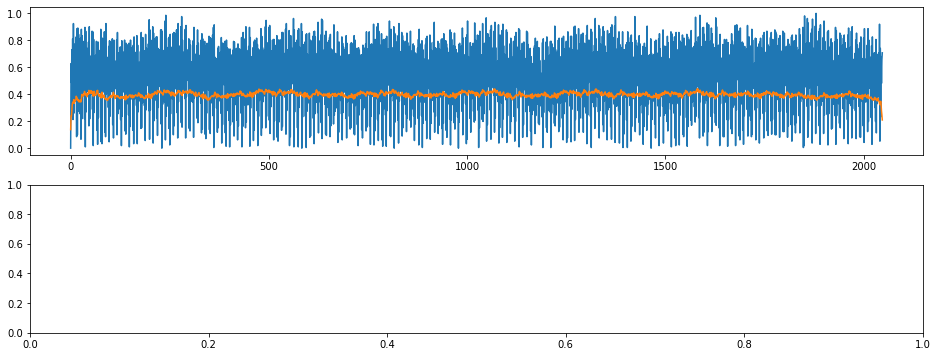

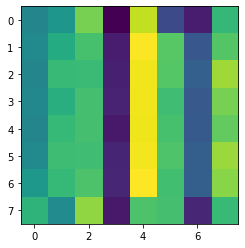

index:  177196
MAE:  0.26026576880047914
n_bunches       987
bunch_index     805
bunch_number    264
Name: 6678209, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6616/instability_data/06616_Inst_B1H_Q7_20180427_12h51m14s.h5


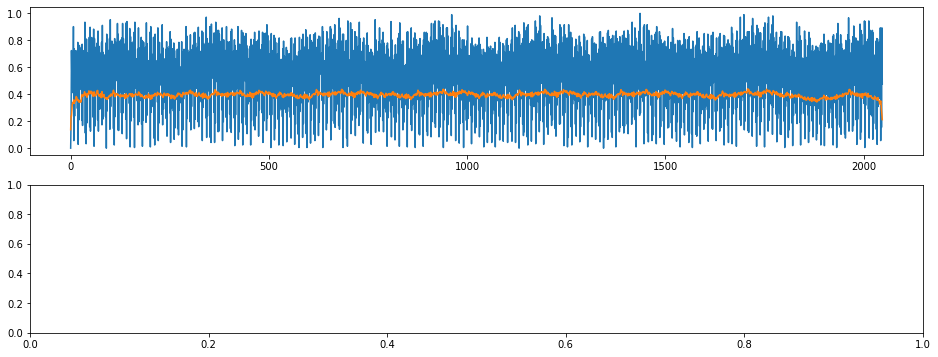

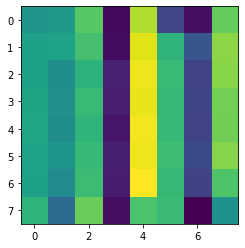

index:  214798
MAE:  0.2602053133599054
n_bunches        924
bunch_index     1144
bunch_number     828
Name: 10174733, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7035/instability_data/07035_Inst_B1H_Q7_20180807_16h51m50s.h5


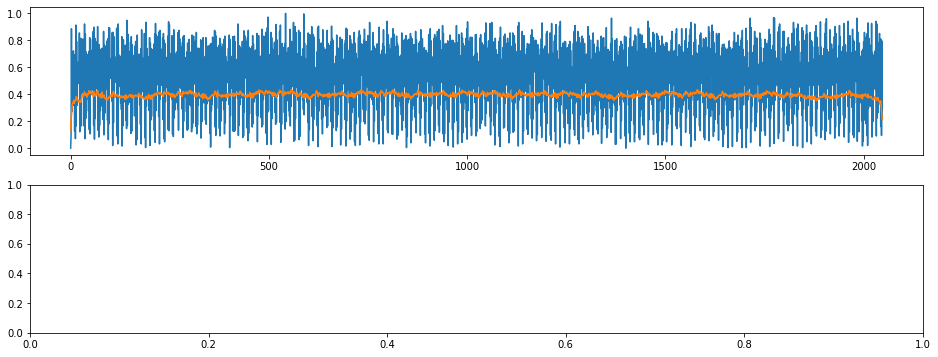

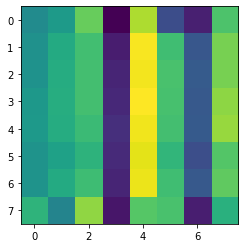

index:  179562
MAE:  0.26007155760384676
n_bunches       228
bunch_index     132
bunch_number     88
Name: 2353967, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6602/instability_data/06602_Inst_B1H_Q7_20180423_17h04m16s.h5


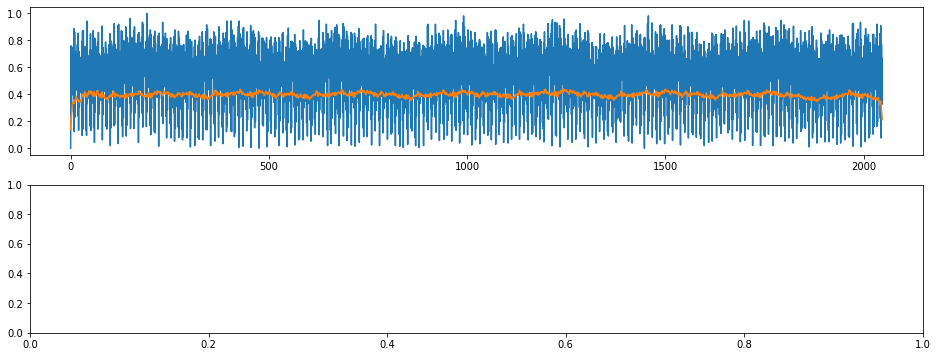

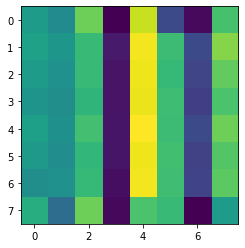

index:  220811
MAE:  0.25990668483920343
n_bunches        588
bunch_index     1727
bunch_number     456
Name: 8531586, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6807/instability_data/06807_Inst_B1H_Q7_20180616_03h53m15s.h5


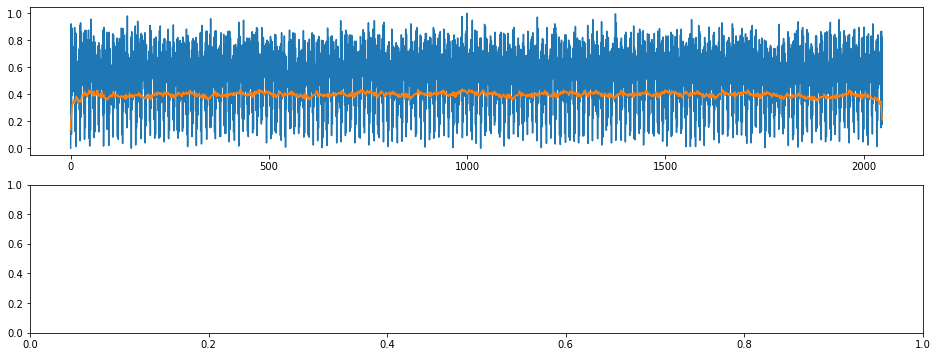

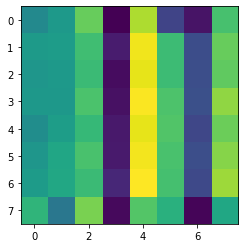

index:  253494
MAE:  0.2598048575409511
n_bunches       268
bunch_index     301
bunch_number    135
Name: 8033512, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6399/instability_data/06399_Inst_B1H_Q7_20171120_12h23m59s.h5


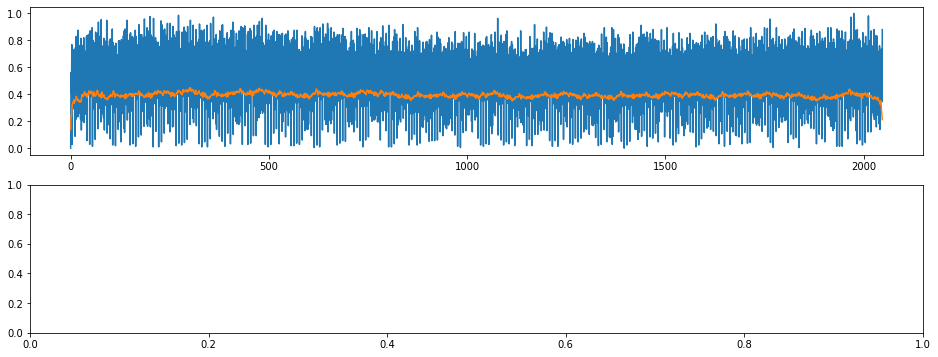

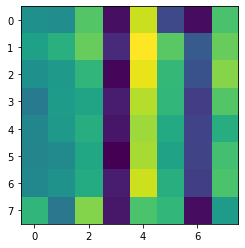

index:  175759
MAE:  0.25952534478003536
n_bunches       924
bunch_index     714
bunch_number    523
Name: 7659109, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7065/instability_data/07065_Inst_B1H_Q7_20180819_08h34m00s.h5


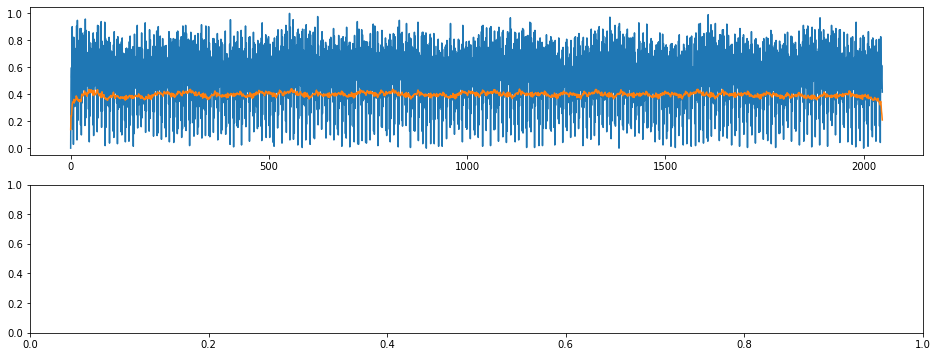

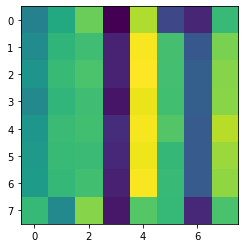

index:  253353
MAE:  0.2593537148806274
n_bunches       2556
bunch_index     1307
bunch_number     934
Name: 4946515, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_11h22m14s.h5


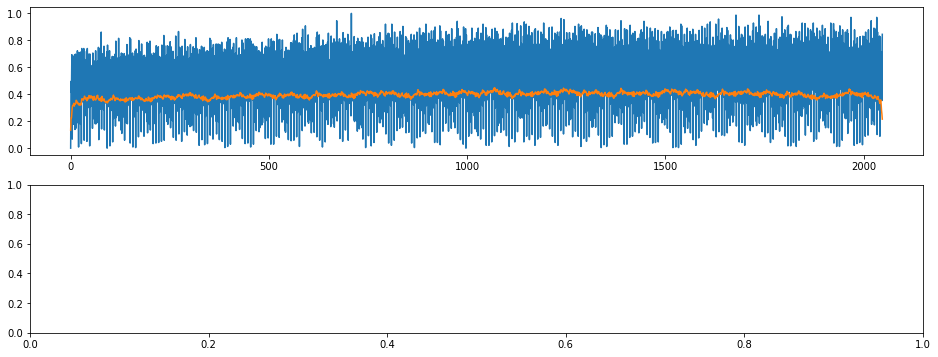

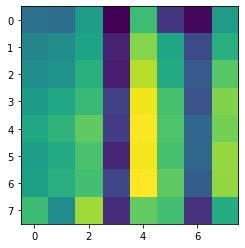

index:  251164
MAE:  0.2592512056653504
n_bunches       1887
bunch_index     1973
bunch_number    1085
Name: 1289271, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6633/instability_data/06633_Inst_B1H_Q7_20180502_06h15m14s.h5


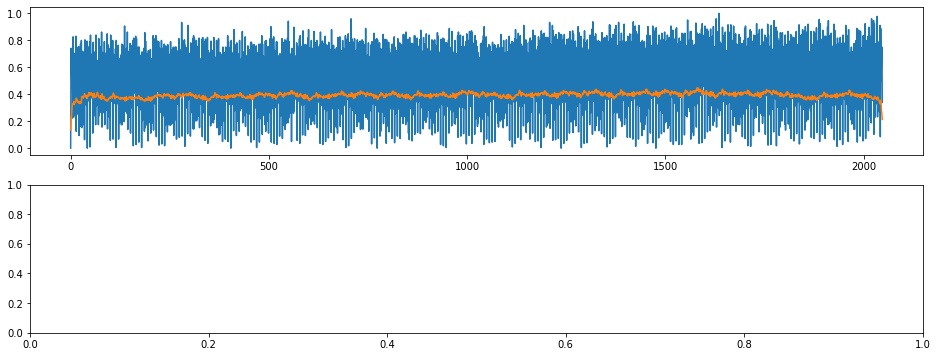

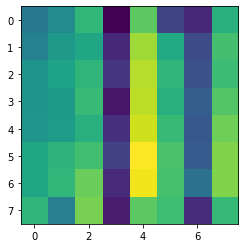

index:  174551
MAE:  0.2592027399888863
n_bunches       157
bunch_index     221
bunch_number     34
Name: 9766157, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6799/instability_data/06799_Inst_B1H_Q7_20180615_09h55m15s.h5


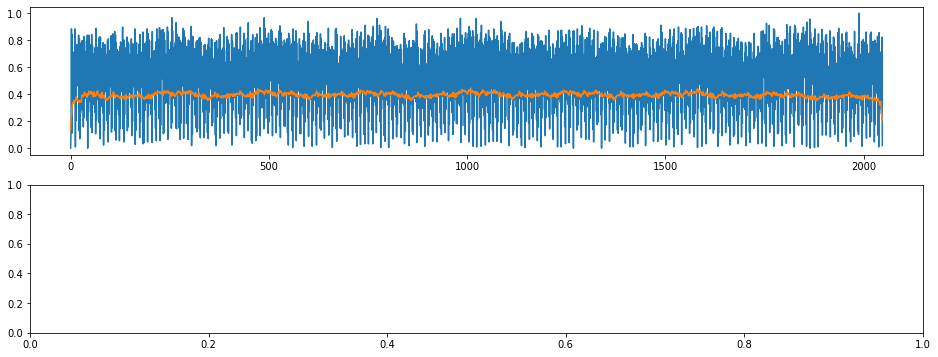

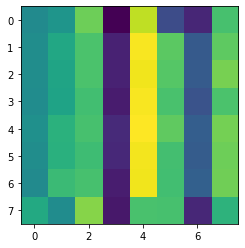

index:  253443
MAE:  0.2589959399280407
n_bunches       1916
bunch_index     1067
bunch_number     572
Name: 1064931, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6189/instability_data/06189_Inst_B1H_Q7_20170911_07h18m14s.h5


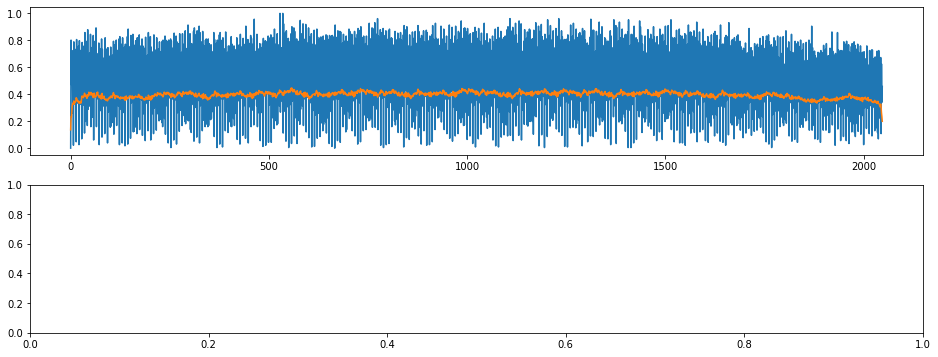

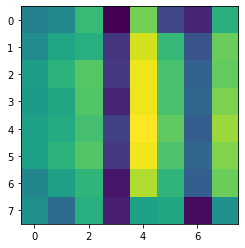

index:  173586
MAE:  0.2589294261577746
n_bunches        648
bunch_index     2527
bunch_number     475
Name: 10716682, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_06h05m15s.h5


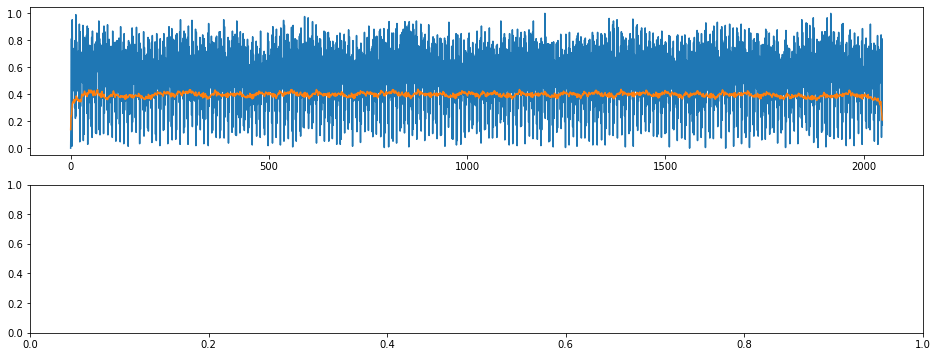

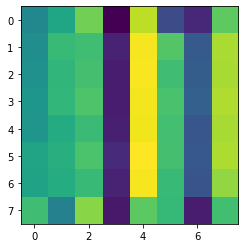

index:  251293
MAE:  0.2588908275074614
n_bunches       636
bunch_index     175
bunch_number    100
Name: 7359263, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6659/instability_data/06659_Inst_B1H_Q7_20180509_00h22m16s.h5


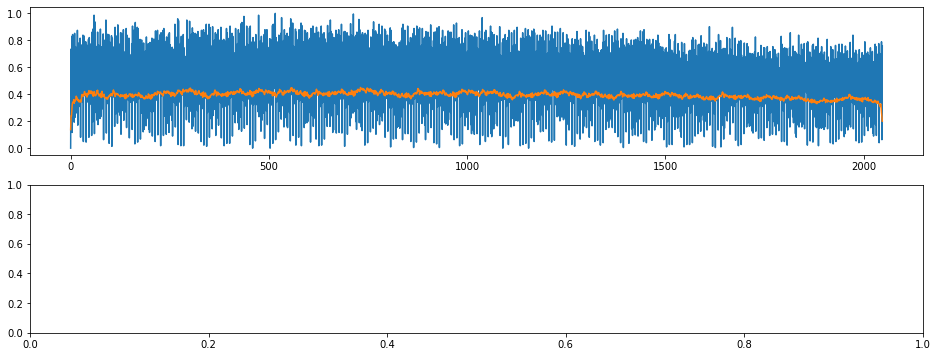

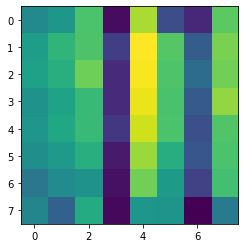

index:  253564
MAE:  0.25854232728046334
n_bunches       1452
bunch_index     2142
bunch_number     901
Name: 1423432, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180706_11h57m14s.h5


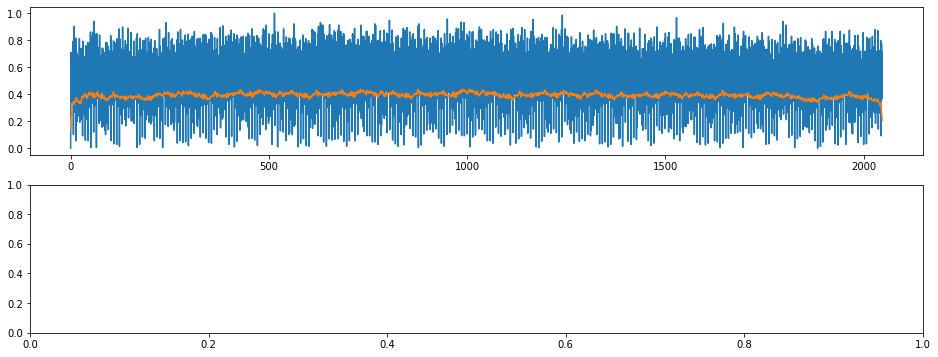

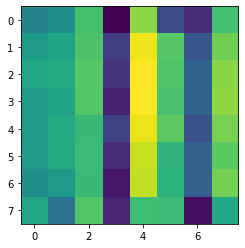

index:  251083
MAE:  0.2585381303933153
n_bunches        565
bunch_index     1570
bunch_number     331
Name: 11236490, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_08h38m41s.h5


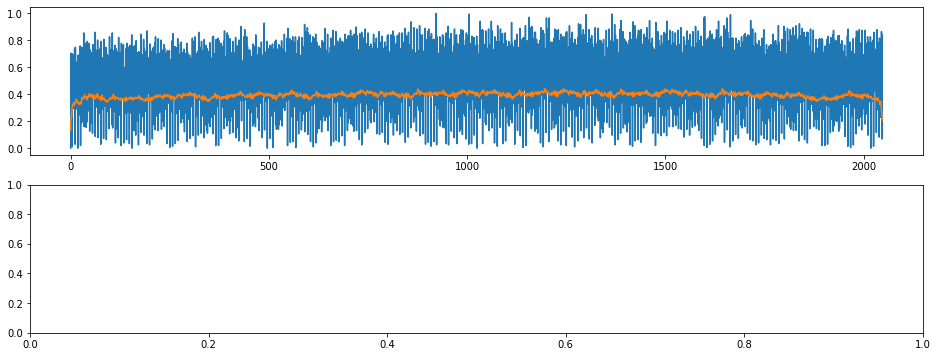

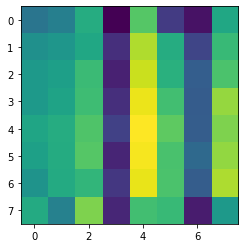

In [37]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Generating an latent space image dataset

In [38]:
latent_dataset = []
latent_metadata = []
latent_input_data = []
for i in tqdm(range(65536)):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    input_data = train_dataset[anomalous_index][None, :]
    encoding_output = encoding_model(input_data)
    latent_dataset.append(encoding_output)
    latent_input_data.append(input_data)
    # get the metadata
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    latent_metadata.append(metadata_row)
#     break

latent_dataset = np.vstack(latent_dataset)
latent_input_data = np.vstack(latent_input_data)
latent_metadata = pd.DataFrame(latent_metadata)

In [39]:
latent_metadata = pd.DataFrame(latent_metadata)

In [40]:
model_latent_space_folder = latent_space_folder / model_path.name
model_latent_space_file = model_latent_space_folder / f'latent_space_{latent_dataset.shape[0]}.npy'
model_latent_space_metadata_file = model_latent_space_folder / f'metadata_latent_space_{latent_dataset.shape[0]}.h5'
model_train_dataset_file = model_latent_space_folder / f'train_dataset_{train_dataset.shape[0]}.npy'
model_latent_input_file = model_latent_space_folder/ f"latent_input_{latent_input_data.shape[0]}.npy"
model_train_max_MAE_file = model_latent_space_folder / f'train_max_MAE_{max_MAE_indices.shape[0]}.npy'

In [41]:
if not model_latent_space_folder.is_dir():
    model_latent_space_folder.mkdir()

In [42]:
np.save(model_latent_space_file, latent_dataset)

In [43]:
latent_metadata.to_hdf(model_latent_space_metadata_file, 'data')

In [44]:
np.save(model_train_dataset_file, train_dataset)

OSError: [Errno 122] Disk quota exceeded

In [ ]:
np.save(model_train_max_MAE_file, max_MAE_indices)

In [ ]:
np.save(model_latent_input_file, latent_input_data)